In [41]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import dense_to_sparse

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

import networkx as nx
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt


## Data Loading and Preprocessing

In [42]:
# Load phenotype file exactly as you did
pheno = pd.read_csv('./Phenotypic_V1_0b_preprocessed1.csv')
pheno = pheno.iloc[1:].reset_index(drop=True)

print("Dataset Overview:")
print(f"Total subjects: {len(pheno)}")
print(f"Columns: {pheno.columns.tolist()}")
print(f"Shape: {pheno.shape}")
print("\nFirst few rows:")
display(pheno.head())
print("\nData types:")
print(pheno.dtypes)

diagnosis_cols = ['DX_GROUP', 'DX', 'diagnosis', 'dx_group', 'group']
diagnosis_col = None

for col in diagnosis_cols:
    if col in pheno.columns:
        diagnosis_col = col
        break

if diagnosis_col is None:
    print("Available columns:")
    print(pheno.columns.tolist())
    raise ValueError("Could not find diagnosis column")

print(f"Using diagnosis column: {diagnosis_col}")
print(f"Diagnosis value counts:")
print(pheno[diagnosis_col].value_counts())
print(f"Unique values: {pheno[diagnosis_col].unique()}")

# Convert to binary
unique_values = pheno[diagnosis_col].unique()
print(f"\nConverting diagnosis to binary...")

if set(unique_values) == {1, 2}:
    pheno['diagnosis_binary'] = (pheno[diagnosis_col] == 1).astype(int)  # 1=ASD, 2=Control -> 1=ASD, 0=Control
    print("Converted: 1=ASD->1, 2=Control->0")
elif set(unique_values) == {0, 1}:
    pheno['diagnosis_binary'] = pheno[diagnosis_col]  # Already binary
    print("Already binary: keeping as is")
else:
    # Try string labels
    if pheno[diagnosis_col].dtype == 'object':
        asd_labels = ['ASD', 'Autism', 'autism', '1', 'case']
        pheno['diagnosis_binary'] = pheno[diagnosis_col].isin(asd_labels).astype(int)
        print(f"String conversion: ASD labels {asd_labels} -> 1, others -> 0")
    else:
        raise ValueError(f"Cannot interpret diagnosis values: {unique_values}")

print(f"\nFinal binary diagnosis distribution:")
print(f"  0 (Control): {sum(pheno['diagnosis_binary'] == 0)}")
print(f"  1 (ASD): {sum(pheno['diagnosis_binary'] == 1)}")
print(f"  Total: {len(pheno)}")

# Check for missing values
print(f"\nMissing diagnosis labels: {pheno['diagnosis_binary'].isna().sum()}")


Dataset Overview:
Total subjects: 1111
Columns: ['Unnamed: 0.1', 'Unnamed: 0', 'SUB_ID', 'X', 'subject', 'SITE_ID', 'FILE_ID', 'DX_GROUP', 'DSM_IV_TR', 'AGE_AT_SCAN', 'SEX', 'HANDEDNESS_CATEGORY', 'HANDEDNESS_SCORES', 'FIQ', 'VIQ', 'PIQ', 'FIQ_TEST_TYPE', 'VIQ_TEST_TYPE', 'PIQ_TEST_TYPE', 'ADI_R_SOCIAL_TOTAL_A', 'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 'ADI_R_ONSET_TOTAL_D', 'ADI_R_RSRCH_RELIABLE', 'ADOS_MODULE', 'ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV', 'ADOS_RSRCH_RELIABLE', 'ADOS_GOTHAM_SOCAFFECT', 'ADOS_GOTHAM_RRB', 'ADOS_GOTHAM_TOTAL', 'ADOS_GOTHAM_SEVERITY', 'SRS_VERSION', 'SRS_RAW_TOTAL', 'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION', 'SRS_MOTIVATION', 'SRS_MANNERISMS', 'SCQ_TOTAL', 'AQ_TOTAL', 'COMORBIDITY', 'CURRENT_MED_STATUS', 'MEDICATION_NAME', 'OFF_STIMULANTS_AT_SCAN', 'VINELAND_RECEPTIVE_V_SCALED', 'VINELAND_EXPRESSIVE_V_SCALED', 'VINELAND_WRITTEN_V_SCALED', 'VINELAND_COMMUNICATION_STANDARD', 'VINELAND_PERSONAL_V_SCALED', 'VINELAND_DOMESTIC

,Unnamed: 0.1,Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
1,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
3,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1
4,5,6,50007,6,50007,PITT,Pitt_0050007,1,1,17.78,...,NaN,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1



Data types:
Unnamed: 0.1              int64
Unnamed: 0                int64
SUB_ID                    int64
X                         int64
subject                   int64
                          ...  
qc_anat_rater_3          object
qc_anat_notes_rater_3    object
qc_func_rater_3          object
qc_func_notes_rater_3    object
SUB_IN_SMP                int64
Length: 106, dtype: object
Using diagnosis column: DX_GROUP
Diagnosis value counts:
DX_GROUP
2    573
1    538
Name: count, dtype: int64
Unique values: [1 2]

Converting diagnosis to binary...
Converted: 1=ASD->1, 2=Control->0

Final binary diagnosis distribution:
  0 (Control): 573
  1 (ASD): 538
  Total: 1111

Missing diagnosis labels: 0


In [43]:
print("IMPORTANT: Phenotype data used ONLY for labels, NOT as model features")
print("="*60)

# Look at diagnosis distribution
print("Diagnosis Information (PRIMARY OUTCOME):")
print(f"Binary diagnosis distribution:")
print(f"  0 (Control): {sum(pheno['diagnosis_binary'] == 0)}")
print(f"  1 (ASD): {sum(pheno['diagnosis_binary'] == 1)}")

# Check for missing values in labels
print(f"Missing diagnosis labels: {pheno['diagnosis_binary'].isna().sum()}")

# Look at other variables for descriptive purposes only
descriptive_cols = ['SUB_ID', 'SITE_ID', 'AGE_AT_SCAN', 'SEX', 'HANDEDNESS_LR', 'FIQ']
available_desc_cols = [col for col in descriptive_cols if col in pheno.columns]

print(f"\nDescriptive variables (NOT used as model features):")
for col in available_desc_cols[:3]:  # Just show first 3
    print(f"\n{col}:")
    if pheno[col].dtype == 'object':
        print(f"  Value counts: {pheno[col].value_counts().to_dict()}")
    else:
        print(f"  Mean±SD: {pheno[col].mean():.2f}±{pheno[col].std():.2f}")
        print(f"  Range: {pheno[col].min():.2f} to {pheno[col].max():.2f}")
    print(f"  Missing: {pheno[col].isna().sum()}")

print("\nNOTE: These demographic variables are for description only.")
print("The model will use ONLY structural MRI features for classification.")


IMPORTANT: Phenotype data used ONLY for labels, NOT as model features
Diagnosis Information (PRIMARY OUTCOME):
Binary diagnosis distribution:
  0 (Control): 573
  1 (ASD): 538
Missing diagnosis labels: 0

Descriptive variables (NOT used as model features):

SUB_ID:
  Mean±SD: 50753.36±447.31
  Range: 50003.00 to 51607.00
  Missing: 0

SITE_ID:
  Value counts: {'NYU': 184, 'UM_1': 110, 'USM': 101, 'UCLA_1': 82, 'MAX_MUN': 57, 'PITT': 56, 'YALE': 56, 'KKI': 55, 'TRINITY': 49, 'STANFORD': 40, 'CALTECH': 38, 'SDSU': 36, 'OLIN': 36, 'UM_2': 35, 'LEUVEN_2': 35, 'SBL': 30, 'LEUVEN_1': 29, 'OHSU': 28, 'UCLA_2': 27, 'CMU': 27}
  Missing: 0

AGE_AT_SCAN:
  Mean±SD: 17.05±8.04
  Range: 6.47 to 64.00
  Missing: 0

NOTE: These demographic variables are for description only.
The model will use ONLY structural MRI features for classification.


In [44]:
import os

data_folder = "freesurfer"
print("Available files in freesurfer folder:")
if os.path.exists(data_folder):
    files = os.listdir(data_folder)
    for file in sorted(files):
        print(f"  {file}")
        
    # Check if merged file exists
    merged_file = "merged_freesurfer.csv"
    if merged_file in files:
        print(f"\n✓ Found merged FreeSurfer file: {merged_file}")
        
        # Get a preview of the merged file
        merged_path = f"{data_folder}/{merged_file}"
        sample_merged = pd.read_csv(merged_path, nrows=5)  # Just first 5 rows
        
        print(f"Merged file preview:")
        print(f"  Shape: {sample_merged.shape}")
        print(f"  Columns: {len(sample_merged.columns)}")
        print(f"  Sample columns: {list(sample_merged.columns)[:10]}...")
        
        # Try to identify feature types
        columns = list(sample_merged.columns)
        lh_cols = [col for col in columns if 'lh' in col.lower()]
        rh_cols = [col for col in columns if 'rh' in col.lower()]
        other_cols = [col for col in columns if col not in lh_cols + rh_cols]
        
        print(f"  Left hemisphere columns: {len(lh_cols)}")
        print(f"  Right hemisphere columns: {len(rh_cols)}")
        print(f"  Other columns: {len(other_cols)}")
        print(f"  Sample other columns: {other_cols[:5]}")
        
    else:
        print(f"\n✗ Merged FreeSurfer file not found: {merged_file}")
        print("Available files:", files)
else:
    print(f"Folder {data_folder} not found!")


Available files in freesurfer folder:
  aseg_table.tsv
  brainstats_abide_with_pial.txt
  lh.aparc_table_area.tsv
  lh.aparc_table_thickness.tsv
  lh.aparc_table_volume.tsv
  merged_freesurfer.csv
  rh.aparc_table_area.tsv
  rh.aparc_table_thickness.tsv
  rh.aparc_table_volume.tsv

✓ Found merged FreeSurfer file: merged_freesurfer.csv
Merged file preview:
  Shape: (5, 278)
  Columns: 278
  Sample columns: ['subject', 'Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent', 'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex', 'Left-Thalamus-Proper', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum', '3rd-Ventricle']...
  Left hemisphere columns: 109
  Right hemisphere columns: 112
  Other columns: 60
  Sample other columns: ['subject', 'Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent', 'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex']


In [45]:
print("LOADING MERGED FREESURFER DATA")
print("="*40)

if not os.path.exists(merged_path):
    print(f"ERROR: Merged FreeSurfer file not found at {merged_path}")
    if os.path.exists(data_folder):
        files = os.listdir(data_folder)
        print(f"Available files in {data_folder}:")
        for file in sorted(files):
            print(f"  {file}")
    else:
        print(f"Directory {data_folder} not found!")
    raise FileNotFoundError(f"Cannot find {merged_path}")

# Load merged FreeSurfer data
print(f"Loading: {merged_path}")
freesurfer_data = pd.read_csv(merged_path)

print(f"✓ Loaded FreeSurfer data: {freesurfer_data.shape}")
print(f"  Subjects: {len(freesurfer_data)}")
print(f"  Total columns: {len(freesurfer_data.columns)}")

# Show sample columns
print(f"\nSample columns:")
for i, col in enumerate(freesurfer_data.columns[:10]):
    print(f"  {i+1:2d}. {col}")
if len(freesurfer_data.columns) > 10:
    print(f"  ... and {len(freesurfer_data.columns) - 10} more")

print("MERGING PHENOTYPE LABELS WITH FREESURFER DATA")
print("="*50)

# Find subject ID columns for merging
pheno_id_col = 'FILE_ID'

fs_id_col = 'subject'

print(f"Phenotype subject ID column: {pheno_id_col}")
print(f"FreeSurfer subject ID column: {fs_id_col}")

# Merge data
if pheno_id_col and fs_id_col:
    # Convert both to string for robust matching
    pheno[pheno_id_col] = pheno[pheno_id_col].astype(str)
    freesurfer_data[fs_id_col] = freesurfer_data[fs_id_col].astype(str)
    
    print(f"\nMerging on subject IDs...")
    print(f"  Phenotype subjects: {len(pheno)}")
    print(f"  FreeSurfer subjects: {len(freesurfer_data)}")
    
    # Merge keeping only subjects with both phenotype and FreeSurfer data
    combined_data = pd.merge(
        pheno[['diagnosis_binary', pheno_id_col]], 
        freesurfer_data, 
        left_on=pheno_id_col, 
        right_on=fs_id_col, 
        how='inner'
    )
    
    # Remove duplicate ID column if different names
    if fs_id_col != pheno_id_col and fs_id_col in combined_data.columns:
        combined_data = combined_data.drop(columns=[fs_id_col])
        
    print(f"  ✓ Successfully merged: {len(combined_data)} subjects")
    
else:
    print("WARNING: No matching subject ID columns found!")
    print("Assuming same order (risky approach)")
    
    # Assume same order - take minimum length
    n_subjects = min(len(pheno), len(freesurfer_data))
    
    combined_data = pd.concat([
        pheno[['diagnosis_binary']].iloc[:n_subjects].reset_index(drop=True),
        freesurfer_data.iloc[:n_subjects].reset_index(drop=True)
    ], axis=1)
    
    print(f"  Combined subjects: {n_subjects}")

print(f"\nFinal combined dataset: {combined_data.shape}")

LOADING MERGED FREESURFER DATA
Loading: freesurfer/merged_freesurfer.csv
✓ Loaded FreeSurfer data: (1035, 278)
  Subjects: 1035
  Total columns: 278

Sample columns:
   1. subject
   2. Left-Lateral-Ventricle
   3. Left-Inf-Lat-Vent
   4. Left-Cerebellum-White-Matter
   5. Left-Cerebellum-Cortex
   6. Left-Thalamus-Proper
   7. Left-Caudate
   8. Left-Putamen
   9. Left-Pallidum
  10. 3rd-Ventricle
  ... and 268 more
MERGING PHENOTYPE LABELS WITH FREESURFER DATA
Phenotype subject ID column: FILE_ID
FreeSurfer subject ID column: subject

Merging on subject IDs...
  Phenotype subjects: 1111
  FreeSurfer subjects: 1035
  ✓ Successfully merged: 1035 subjects

Final combined dataset: (1035, 279)


## Look at Features

In [46]:
print("FEATURE CATEGORIZATION")
print("="*30)

# Identify structural features (exclude ID and label columns)
exclude_cols = ['diagnosis_binary', pheno_id_col, fs_id_col, 'subject_id', 'subject', 'SUB_ID', 'SUBJECTID', 'ID', 'id']
exclude_cols = [col for col in exclude_cols if col in combined_data.columns and col is not None]

structural_cols = [col for col in combined_data.columns if col not in exclude_cols]

# Categorize structural features
cortical_features = [col for col in structural_cols if any(x in col for x in ['lh_', 'rh_', 'lh.', 'rh.'])]
subcortical_features = [col for col in structural_cols if any(x in col for x in ['subcortical', 'aseg', 'Left-', 'Right-'])]
other_features = [col for col in structural_cols if col not in cortical_features + subcortical_features]

print(f"Dataset composition:")
print(f"  Exclude columns: {len(exclude_cols)} - {exclude_cols}")
print(f"  Total structural features: {len(structural_cols)}")
print(f"    Cortical features: {len(cortical_features)}")
print(f"    Subcortical features: {len(subcortical_features)}")
print(f"    Other features: {len(other_features)}")

print(f"\nSample cortical features: {cortical_features[:5]}")
if subcortical_features:
    print(f"Sample subcortical features: {subcortical_features[:5]}")
if other_features:
    print(f"Sample other features: {other_features[:5]}")

# Check diagnosis distribution in final dataset
print(f"\nFinal diagnosis distribution:")
print(combined_data['diagnosis_binary'].value_counts())

# Check for missing values
missing_count = combined_data[structural_cols].isnull().sum().sum()
if missing_count > 0:
    print(f"\nWARNING: {missing_count} missing values found in structural features")
    missing_by_feature = combined_data[structural_cols].isnull().sum()
    features_with_missing = missing_by_feature[missing_by_feature > 0]
    print(f"Features with missing values: {len(features_with_missing)}")
    if len(features_with_missing) <= 10:
        print(features_with_missing)
else:
    print(f"\n✓ No missing values in structural features")

print(f"\n✓ STRUCTURAL-ONLY DATASET READY")
print(f"Model will use {len(structural_cols)} structural brain features")


FEATURE CATEGORIZATION
Dataset composition:
  Exclude columns: 2 - ['diagnosis_binary', 'FILE_ID']
  Total structural features: 277
    Cortical features: 208
    Subcortical features: 32
    Other features: 37

Sample cortical features: ['lh_bankssts_thickness', 'lh_caudalanteriorcingulate_thickness', 'lh_caudalmiddlefrontal_thickness', 'lh_cuneus_thickness', 'lh_entorhinal_thickness']
Sample subcortical features: ['Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent', 'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex', 'Left-Thalamus-Proper']
Sample other features: ['3rd-Ventricle', '4th-Ventricle', 'Brain-Stem', 'CSF', '5th-Ventricle']

Final diagnosis distribution:
diagnosis_binary
0    530
1    505
Name: count, dtype: int64

✓ No missing values in structural features

✓ STRUCTURAL-ONLY DATASET READY
Model will use 277 structural brain features


## Extract Regional Features

In [47]:
def extract_regional_matrices(combined_data, structural_cols):
    """Extract regional feature matrices from structural data"""
    
    print("EXTRACTING REGIONAL FEATURE MATRICES")
    print("="*40)
    
    # Parse structural columns to identify regions and metrics
    regions_data = {}
    
    for col in structural_cols:
        # Try to parse FreeSurfer column format
        if any(prefix in col for prefix in ['lh_', 'rh_', 'lh.', 'rh.']):
            # Parse format like 'lh_area_bankssts' or 'lh.aparc.thickness'
            if '_' in col:
                parts = col.split('_')
                hemisphere = parts[0]  # lh or rh
                metric = parts[1] if len(parts) > 1 else 'unknown'
                region = '_'.join(parts[2:]) if len(parts) > 2 else 'unknown'
            elif '.' in col:
                parts = col.split('.')
                hemisphere = parts[0]  # lh or rh
                metric = parts[-1] if len(parts) > 1 else 'unknown'
                region = '.'.join(parts[1:-1]) if len(parts) > 2 else 'unknown'
            else:
                hemisphere = col[:2] if len(col) >= 2 else 'unknown'
                metric = 'unknown'
                region = col[2:] if len(col) > 2 else 'unknown'
            
            # Create full region name
            full_region = f"{hemisphere}_{region}"
            
            if full_region not in regions_data:
                regions_data[full_region] = {}
                
            regions_data[full_region][metric] = combined_data[col].values
        else:
            # Handle non-standard naming or subcortical structures
            # Treat as single feature per "region"
            regions_data[col] = {'volume': combined_data[col].values}
    
    # Convert to matrix format
    region_names = sorted(regions_data.keys())
    
    # Find all available metrics
    all_metrics = set()
    for region_data in regions_data.values():
        all_metrics.update(region_data.keys())
    metric_names = sorted(list(all_metrics))
    
    print(f"Parsed structural data:")
    print(f"  Regions found: {len(region_names)}")
    print(f"  Metrics found: {metric_names}")
    print(f"  Sample regions: {region_names[:10]}")
    
    # Create feature matrix
    n_subjects = len(combined_data)
    n_regions = len(region_names)
    n_metrics = len(metric_names)
    
    regional_features = np.zeros((n_subjects, n_regions, n_metrics))
    
    for i, region in enumerate(region_names):
        for j, metric in enumerate(metric_names):
            if metric in regions_data[region]:
                regional_features[:, i, j] = regions_data[region][metric]
            else:
                # Fill missing metrics with zeros
                regional_features[:, i, j] = 0
                
    print(f"\nRegional feature matrix: {regional_features.shape}")
    print(f"  (n_subjects, n_regions, n_metrics) = ({n_subjects}, {n_regions}, {n_metrics})")
    
    # Check for issues
    n_nan = np.sum(np.isnan(regional_features))
    n_inf = np.sum(np.isinf(regional_features))
    
    print(f"  NaN values: {n_nan}")
    print(f"  Infinite values: {n_inf}")
    
    if n_nan > 0 or n_inf > 0:
        print("  Replacing NaN/Inf with zeros...")
        regional_features = np.nan_to_num(regional_features)
    
    return {
        'features': regional_features,
        'region_names': region_names,
        'metric_names': metric_names
    }

# Extract regional matrices
regional_data = extract_regional_matrices(combined_data, structural_cols)
print(f"\n✓ Regional feature extraction complete!")

EXTRACTING REGIONAL FEATURE MATRICES
Parsed structural data:
  Regions found: 75
  Metrics found: ['MeanThickness', 'WhiteSurfArea', 'bankssts', 'caudalanteriorcingulate', 'caudalmiddlefrontal', 'cuneus', 'entorhinal', 'frontalpole', 'fusiform', 'inferiorparietal', 'inferiortemporal', 'insula', 'isthmuscingulate', 'lateraloccipital', 'lateralorbitofrontal', 'lingual', 'medialorbitofrontal', 'middletemporal', 'paracentral', 'parahippocampal', 'parsopercularis', 'parsorbitalis', 'parstriangularis', 'pericalcarine', 'postcentral', 'posteriorcingulate', 'precentral', 'precuneus', 'rostralanteriorcingulate', 'rostralmiddlefrontal', 'superiorfrontal', 'superiorparietal', 'superiortemporal', 'supramarginal', 'temporalpole', 'transversetemporal', 'volume']
  Sample regions: ['3rd-Ventricle', '4th-Ventricle', '5th-Ventricle', 'Brain-Stem', 'CC_Anterior', 'CC_Central', 'CC_Mid_Anterior', 'CC_Mid_Posterior', 'CC_Posterior', 'CSF']

Regional feature matrix: (1035, 75, 37)
  (n_subjects, n_regions,

## Feature Engineering

In [48]:
class StructuralFeatureEngineer:
    """Engineer comprehensive structural features for each brain region"""
    
    def __init__(self):
        self.scaler = StandardScaler()
        
    def engineer_features(self, regional_features, verbose=True):
        """Engineer comprehensive features from structural data only"""
        
        n_subjects, n_regions, n_raw_metrics = regional_features.shape
        
        if verbose:
            print("ENGINEERING STRUCTURAL-ONLY FEATURES")
            print("="*40)
            print(f"Input: {n_subjects} subjects, {n_regions} regions, {n_raw_metrics} raw metrics")
            print("NOTE: Using ONLY structural MRI data, no demographic features")
        
        all_features = []
        feature_names = []
        
        # 1. Normalized raw metrics
        if verbose:
            print("\n1. Normalizing raw structural metrics...")
        
        for i in range(n_raw_metrics):
            metric_data = regional_features[:, :, i]
            
            # Z-score normalize across subjects for each region
            metric_normalized = np.zeros_like(metric_data)
            for region in range(n_regions):
                region_data = metric_data[:, region]
                if np.std(region_data) > 0:
                    metric_normalized[:, region] = (region_data - np.mean(region_data)) / np.std(region_data)
                
            all_features.append(metric_normalized)
            feature_names.append(f'norm_metric_{i}')
        
        # 2. Morphometric ratios
        if verbose:
            print("2. Computing morphometric ratios...")
            
        if n_raw_metrics >= 2:
            ratio_1 = np.divide(regional_features[:, :, 0], 
                               regional_features[:, :, 1] + 1e-8)
            all_features.append(ratio_1)
            feature_names.append('ratio_metric_0_1')
            
        if n_raw_metrics >= 3:
            ratio_2 = np.divide(regional_features[:, :, 2], 
                               regional_features[:, :, 1] + 1e-8)
            all_features.append(ratio_2)
            feature_names.append('ratio_metric_2_1')
        
        # 3. Within-subject regional rankings
        if verbose:
            print("3. Computing within-subject regional rankings...")
            
        for i in range(min(3, n_raw_metrics)):
            metric_data = regional_features[:, :, i]
            ranking_features = np.zeros_like(metric_data)
            
            for subj in range(n_subjects):
                subj_data = metric_data[subj, :]
                if np.std(subj_data) > 0:
                    ranking_features[subj, :] = np.argsort(np.argsort(subj_data)) / (n_regions - 1)
                
            all_features.append(ranking_features)
            feature_names.append(f'rank_metric_{i}')
        
        # 4. Hemispheric asymmetry
        if verbose:
            print("4. Computing hemispheric asymmetry...")
            
        asymmetry_features = self._compute_asymmetry(regional_features, n_raw_metrics)
        if asymmetry_features:
            all_features.extend(asymmetry_features)
            feature_names.extend([f'asymmetry_metric_{i}' for i in range(len(asymmetry_features))])
        
        # 5. Regional contrast (vs whole brain)
        if verbose:
            print("5. Computing regional contrast features...")
            
        for i in range(min(3, n_raw_metrics)):
            metric_data = regional_features[:, :, i]
            
            # Each region compared to subject's global mean
            global_mean = np.mean(metric_data, axis=1, keepdims=True)
            regional_contrast = metric_data - global_mean
            
            # Normalize by global std
            global_std = np.std(metric_data, axis=1, keepdims=True) + 1e-8
            regional_contrast = regional_contrast / global_std
            
            all_features.append(regional_contrast)
            feature_names.append(f'global_contrast_metric_{i}')
        
        # 6. Regional coefficient of variation
        if verbose:
            print("6. Computing regional variability...")
            
        if n_raw_metrics >= 2:
            regional_cv = np.zeros((n_subjects, n_regions))
            for subj in range(n_subjects):
                for region in range(n_regions):
                    region_metrics = regional_features[subj, region, :]
                    if np.mean(region_metrics) > 0:
                        cv = np.std(region_metrics) / (np.mean(region_metrics) + 1e-8)
                        regional_cv[subj, region] = cv
            
            all_features.append(regional_cv)
            feature_names.append('regional_cv')
        
        # Stack all features
        engineered_features = np.stack(all_features, axis=2)
        
        # Clean up any remaining issues
        engineered_features = np.nan_to_num(engineered_features, 
                                          nan=0.0, posinf=1.0, neginf=-1.0)
        
        # CRITICAL FIX: Scale features properly
        if verbose:
            print("7. Applying robust feature scaling...")
            
        from sklearn.preprocessing import RobustScaler
        n_subjects, n_regions, n_features = engineered_features.shape

        # Reshape for scaling
        features_reshaped = engineered_features.reshape(-1, n_features)
        scaler = RobustScaler()
        features_scaled = scaler.fit_transform(features_reshaped)
        engineered_features = features_scaled.reshape(n_subjects, n_regions, n_features)

        if verbose:
            print(f"  Features scaled: range [{np.min(engineered_features):.3f}, {np.max(engineered_features):.3f}]")
                
        return engineered_features, feature_names
    
    def _compute_asymmetry(self, regional_features, n_metrics):
        """Compute hemispheric asymmetry features"""
        
        n_subjects, n_regions, _ = regional_features.shape
        
        # Simple approach: assume first half are LH, second half are RH
        if n_regions % 2 != 0:
            return None
            
        n_paired_regions = n_regions // 2
        lh_indices = list(range(n_paired_regions))
        rh_indices = list(range(n_paired_regions, n_regions))
        
        asymmetry_features = []
        
        for metric_idx in range(min(3, n_metrics)):
            lh_data = regional_features[:, lh_indices, metric_idx]
            rh_data = regional_features[:, rh_indices, metric_idx]
            
            # Asymmetry index: (L - R) / (L + R + eps)
            asymmetry = np.divide(lh_data - rh_data, 
                                lh_data + rh_data + 1e-8)
            asymmetry_features.append(asymmetry)
        
        return asymmetry_features

# Engineer features
print("Starting feature engineering...")
feature_engineer = StructuralFeatureEngineer()
engineered_features, feature_names = feature_engineer.engineer_features(regional_data['features'])

print(f"\n✓ Feature engineering complete!")
print(f"Engineered {len(feature_names)} features per region")

Starting feature engineering...
ENGINEERING STRUCTURAL-ONLY FEATURES
Input: 1035 subjects, 75 regions, 37 raw metrics
NOTE: Using ONLY structural MRI data, no demographic features

1. Normalizing raw structural metrics...
2. Computing morphometric ratios...
3. Computing within-subject regional rankings...
4. Computing hemispheric asymmetry...
5. Computing regional contrast features...
6. Computing regional variability...
7. Applying robust feature scaling...
  Features scaled: range [-769707411.151, 608400000000.000]

✓ Feature engineering complete!
Engineered 46 features per region


## Graph Builer

In [49]:
class StructuralGraphBuilder:
    """Build structural similarity graphs from engineered features"""
    
    def __init__(self, similarity_metric='correlation', threshold_percentile=10):
        self.similarity_metric = similarity_metric
        self.threshold_percentile = threshold_percentile
        
    def build_graphs(self, features, verbose=True):
        """Build similarity graphs for each subject"""
        
        n_subjects, n_regions, n_features = features.shape
        
        if verbose:
            print("BUILDING STRUCTURAL SIMILARITY GRAPHS")
            print("="*40)
            print(f"Input: {n_subjects} subjects, {n_regions} regions, {n_features} features")
            print(f"Similarity metric: {self.similarity_metric}")
            print(f"Threshold: top {self.threshold_percentile}% connections")
        
        graphs = []
        edge_counts = []
        
        for subj_idx in range(n_subjects):
            if verbose and subj_idx % 100 == 0:
                print(f"  Processing subject {subj_idx+1}/{n_subjects}")
                
            subj_features = features[subj_idx]  # (n_regions, n_features)
            
            # Compute similarity matrix
            if self.similarity_metric == 'correlation':
                similarity_matrix = np.corrcoef(subj_features)
                similarity_matrix = np.nan_to_num(similarity_matrix, nan=0.0)
            else:
                # Euclidean distance-based similarity
                distances = squareform(pdist(subj_features, metric='euclidean'))
                max_dist = np.max(distances)
                similarity_matrix = 1 - (distances / (max_dist + 1e-8))
            
            # Normalize to [0, 1]
            sim_min = np.min(similarity_matrix)
            sim_max = np.max(similarity_matrix)
            if sim_max > sim_min:
                similarity_matrix = (similarity_matrix - sim_min) / (sim_max - sim_min)
            
            # Apply threshold
            threshold_value = np.percentile(similarity_matrix.flatten(), 
                                          100 - self.threshold_percentile)
            
            adjacency_matrix = (similarity_matrix >= threshold_value).astype(float)
            np.fill_diagonal(adjacency_matrix, 0)  # Remove self-loops
            
            # Ensure minimum connectivity
            n_edges = np.sum(adjacency_matrix) / 2
            min_edges = max(n_regions, int(0.05 * n_regions * (n_regions - 1) / 2))
            
            if n_edges < min_edges:
                sorted_similarities = np.sort(similarity_matrix.flatten())[::-1]
                new_threshold = sorted_similarities[2 * min_edges]
                adjacency_matrix = (similarity_matrix >= new_threshold).astype(float)
                np.fill_diagonal(adjacency_matrix, 0)
            
            # Create edge weights
            edge_weights = similarity_matrix * adjacency_matrix
            
            # Convert to PyTorch Geometric format
            edge_index, edge_attr = dense_to_sparse(torch.FloatTensor(edge_weights))
            
            # Create graph data
            graph_data = Data(
                x=torch.FloatTensor(subj_features),
                edge_index=edge_index,
                edge_attr=edge_attr.unsqueeze(1) if edge_attr.numel() > 0 else torch.zeros((edge_index.shape[1], 1))
            )
            
            graphs.append(graph_data)
            edge_counts.append(edge_index.shape[1])
        
        if verbose:
            print(f"\n✓ Graph construction complete!")
            print(f"  Created {len(graphs)} graphs")
            print(f"  Average edges per graph: {np.mean(edge_counts):.1f}")
            print(f"  Edge count range: {min(edge_counts)} - {max(edge_counts)}")
        
        return graphs

# Build graphs
print("Building structural similarity graphs...")
graph_builder = StructuralGraphBuilder(similarity_metric='correlation', threshold_percentile=10)
graphs = graph_builder.build_graphs(engineered_features)

print(f"\n✓ {len(graphs)} graphs created successfully!")

Building structural similarity graphs...
BUILDING STRUCTURAL SIMILARITY GRAPHS
Input: 1035 subjects, 75 regions, 46 features
Similarity metric: correlation
Threshold: top 10% connections
  Processing subject 1/1035
  Processing subject 101/1035
  Processing subject 201/1035
  Processing subject 301/1035
  Processing subject 401/1035
  Processing subject 501/1035
  Processing subject 601/1035
  Processing subject 701/1035
  Processing subject 801/1035
  Processing subject 901/1035
  Processing subject 1001/1035

✓ Graph construction complete!
  Created 1035 graphs
  Average edges per graph: 488.0
  Edge count range: 488 - 488

✓ 1035 graphs created successfully!


## GNN Pipeline

In [67]:
class StructuralASDMaskGNN(nn.Module):
    """
    MaskGNN model for ASD classification using structural MRI data.
    Now applies node masking AFTER GNN layers to preserve full feature propagation.
    """

    def __init__(self, input_dim, hidden_dim=128, num_classes=2, dropout=0.4,
                 node_mask_rate=0.15, edge_mask_rate=0.1, mask_token_rate=0.8):
        super(StructuralASDMaskGNN, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.dropout = dropout

        self.node_mask_rate = node_mask_rate
        self.edge_mask_rate = edge_mask_rate
        self.mask_token_rate = mask_token_rate

        self.node_mask_token = nn.Parameter(torch.zeros(hidden_dim))

        # GNN Layers
        self.gat1 = GATConv(input_dim, 64, heads=8, concat=True, dropout=dropout)
        self.norm1 = nn.LayerNorm(64 * 8)

        self.gat2 = GATConv(64 * 8, 64, heads=4, concat=True, dropout=dropout)
        self.norm2 = nn.LayerNorm(64 * 4)

        self.gcn3 = GCNConv(64 * 4, hidden_dim, improved=True)
        self.norm3 = nn.LayerNorm(hidden_dim)

        self.sage4 = SAGEConv(hidden_dim, hidden_dim)
        self.norm4 = nn.LayerNorm(hidden_dim)

        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

        self.pool_weights = nn.Parameter(torch.tensor([0.5, 0.3, 0.2]))

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.LayerNorm(hidden_dim // 4),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 4, num_classes)
        )

        self.dropout_layer = nn.Dropout(dropout)

    def create_node_masks(self, batch_size, nodes_per_graph, device):
        masks = []
        masked_indices = []
        node_start = 0
        for i in range(batch_size):
            n_nodes = nodes_per_graph[i]
            mask = torch.rand(n_nodes, device=device) < self.node_mask_rate
            global_masked_idx = torch.where(mask)[0] + node_start if mask.sum() > 0 else torch.tensor([], device=device)
            masked_indices.append(global_masked_idx)
            masks.append(mask)
            node_start += n_nodes
        return masks, masked_indices

    def apply_node_masking(self, x, masks, batch, device):
        masked_x = x.clone()
        node_start = 0
        for i, mask in enumerate(masks):
            n_nodes = mask.shape[0]
            node_end = node_start + n_nodes
            masked_node_indices = torch.where(mask)[0] + node_start
            if len(masked_node_indices) > 0:
                mask_decision = torch.rand(len(masked_node_indices), device=device)
                for j, global_idx in enumerate(masked_node_indices):
                    if mask_decision[j] < self.mask_token_rate:
                        masked_x[global_idx] = self.node_mask_token
                    else:
                        random_idx = torch.randint(0, x.shape[0], (1,), device=device)
                        masked_x[global_idx] = x[random_idx]
            node_start = node_end
        return masked_x

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        device = x.device

        # GNN Layers (no masking yet)
        x1 = self.gat1(x, edge_index)
        x1 = self.norm1(x1)
        x1 = F.elu(x1)
        x1 = self.dropout_layer(x1)

        x2 = self.gat2(x1, edge_index)
        x2 = self.norm2(x2)
        x2 = F.elu(x2)
        x2 = self.dropout_layer(x2)

        x3 = self.gcn3(x2, edge_index)
        x3 = self.norm3(x3)
        x3 = F.elu(x3)
        x3 = self.dropout_layer(x3)

        x4 = self.sage4(x3, edge_index)
        if x4.shape[1] == x3.shape[1]:
            x4 = x4 + x3
        x4 = self.norm4(x4)
        x4 = F.elu(x4)
        x4 = self.dropout_layer(x4)

        # Masking happens here on latent features
        if self.training:
            batch_size = batch.max().item() + 1
            nodes_per_graph = [(batch == i).sum().item() for i in range(batch_size)]
            node_masks, _ = self.create_node_masks(batch_size, nodes_per_graph, device)
            x4 = self.apply_node_masking(x4, node_masks, batch, device)

        # Attention and Pooling
        attention_weights = self.attention(x4)
        x_attended = x4 * attention_weights

        pool_mean = global_mean_pool(x_attended, batch)
        pool_max = global_max_pool(x_attended, batch)
        pool_sum = global_add_pool(x_attended, batch)

        weights_norm = F.softmax(self.pool_weights, dim=0)
        pooled = (weights_norm[0] * pool_mean +
                  weights_norm[1] * pool_max +
                  weights_norm[2] * pool_sum)

        # Classification
        output = self.classifier(pooled)
        return output

# Initialize MaskGNN model
input_dim = engineered_features.shape[2]

print("INITIALIZING MASKGNN MODEL")
print("="*30)
print(f"Input dimension: {input_dim}")

# Properly define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = StructuralASDMaskGNN(
    input_dim=input_dim,
    hidden_dim=64,        # Smaller model
    dropout=0.3,          # Less dropout
    node_mask_rate=0.05,  # Much lighter masking
    edge_mask_rate=0.02,  # Much lighter masking
    mask_token_rate=0.8   # Use mask token 80% of time
)

# Move model to device
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ MaskGNN Model initialized!")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Node mask rate: {model.node_mask_rate}")
print(f"  Edge mask rate: {model.edge_mask_rate}")
print(f"  Mask token rate: {model.mask_token_rate}")

INITIALIZING MASKGNN MODEL
Input dimension: 46
Device: cpu
✓ MaskGNN Model initialized!
  Total parameters: 188,342
  Trainable parameters: 188,342
  Node mask rate: 0.05
  Edge mask rate: 0.02
  Mask token rate: 0.8


## Prepare labels for testing

In [68]:
# Extract labels
labels = combined_data['diagnosis_binary'].values
print("PREPARING LABELS AND DATA")
print("="*30)
print(f"Labels shape: {labels.shape}")
print(f"Label distribution:")
print(f"  Control (0): {sum(labels == 0)}")
print(f"  ASD (1): {sum(labels == 1)}")

# Verify alignment
print(f"\nData alignment check:")
print(f"  Number of graphs: {len(graphs)}")
print(f"  Number of labels: {len(labels)}")

if len(graphs) != len(labels):
    print("WARNING: Mismatch between graphs and labels!")
    min_length = min(len(graphs), len(labels))
    graphs = graphs[:min_length]
    labels = labels[:min_length]
    print(f"  Truncated to {min_length} samples")

# Add labels to graphs
print(f"\nAdding labels to graph objects...")
for i, label in enumerate(labels):
    graphs[i].y = torch.LongTensor([label])

print("✓ Labels added successfully!")

# Test data loading
print(f"\nTesting data loading...")
test_loader = DataLoader(graphs[:8], batch_size=4, shuffle=False)

for batch_idx, batch in enumerate(test_loader):
    print(f"  Batch {batch_idx+1}:")
    print(f"    Batch size: {batch.y.shape[0]}")
    print(f"    Node features: {batch.x.shape}")
    print(f"    Edges: {batch.edge_index.shape[1]}")
    print(f"    Labels: {batch.y.squeeze().tolist()}")

print("✓ Data loading test successful!")

PREPARING LABELS AND DATA
Labels shape: (1035,)
Label distribution:
  Control (0): 530
  ASD (1): 505

Data alignment check:
  Number of graphs: 1035
  Number of labels: 1035

Adding labels to graph objects...
✓ Labels added successfully!

Testing data loading...
  Batch 1:
    Batch size: 4
    Node features: torch.Size([300, 46])
    Edges: 1952
    Labels: [1, 1, 1, 1]
  Batch 2:
    Batch size: 4
    Node features: torch.Size([300, 46])
    Edges: 1952
    Labels: [1, 1, 1, 1]
✓ Data loading test successful!


/Users/joemargolis/Desktop/ASD2/.venv/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## TRaining Pipeline

In [69]:
class StructuralASDTrainer:
    """Enhanced training pipeline for MaskGNN with loss"""
    
    def __init__(self, model, device='cuda'):
        self.model = model.to(device)
        self.device = device

        self.lr = 0.0005
        self.weight_decay = 1e-4
        self.batch_size = 16
        self.max_epochs = 100
        self.patience = 15  # early stopping
        
    def setup_training(self, train_labels):
        """Setup optimizer, scheduler, and loss function"""
        
        print("Setting up MaskGNN training components...")
        
        # Optimizer
        self.optimizer = torch.optim.Adam(
            self.model.parameters(), 
            lr=self.lr, 
            weight_decay=self.weight_decay
        )
        
        # Learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=5, factor=0.8
        )
        
        # Class weights (softened)
        class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
        class_weights = 1.0 + 0.2 * (class_weights - 1.0)  # Soften weights
        class_weights = torch.FloatTensor(class_weights).to(self.device)
        
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
        
        print(f"  Optimizer: Adam (lr={self.lr}, weight_decay={self.weight_decay})")
        print(f"  Class weights: {class_weights}")
        print("  ✓ MaskGNN training setup complete!")
        
    def train_epoch(self, train_loader):
        """Train for one epoch """
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            batch = batch.to(self.device)

            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(batch)

            # Classification loss
            classification_loss = self.criterion(outputs, batch.y)
            classification_loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
            self.optimizer.step()

            # Statistics
            total_loss += classification_loss.item()
            _, predicted = outputs.max(1)
            total += batch.y.size(0)
            correct += predicted.eq(batch.y).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total

        return {
            'total_loss': avg_loss,
            'classification_loss': avg_loss,
            'accuracy': accuracy
        }
    
    def evaluate(self, test_loader, return_predictions=False):
        """Evaluate model (no masking during evaluation)"""
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_probabilities = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(self.device)
                
                # Forward pass without masking
                outputs = self.model(batch)
                loss = self.criterion(outputs, batch.y)
                
                total_loss += loss.item()
                probabilities = F.softmax(outputs, dim=1)
                _, predicted = outputs.max(1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())
                all_labels.extend(batch.y.cpu().numpy())
        
        avg_loss = total_loss / len(test_loader)
        
        # Compute metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        auc = roc_auc_score(all_labels, np.array(all_probabilities)[:, 1])
        f1 = f1_score(all_labels, all_predictions)
        sensitivity = recall_score(all_labels, all_predictions)
        specificity = recall_score(all_labels, all_predictions, pos_label=0)
        
        metrics = {
            'loss': avg_loss,
            'accuracy': accuracy,
            'auc': auc,
            'f1': f1,
            'sensitivity': sensitivity,
            'specificity': specificity
        }
        
        if return_predictions:
            return metrics, all_predictions, all_probabilities, all_labels
        
        return metrics

# Initialize MaskGNN trainer
mask_trainer = StructuralASDTrainer(model, device=device)
print("✓ MaskGNN Trainer initialized!")

✓ MaskGNN Trainer initialized!


## Cross Validation Pipeline

In [70]:
def run_cross_validation(graphs, labels, trainer_class, n_splits=5):
    """Run full cross-validation with MaskGNN"""
    
    print(f"\nSTARTING MASKGNN {n_splits}-FOLD CROSS-VALIDATION")
    print("="*55)
    
    # Initialize cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_results = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(graphs, labels)):
        print(f"\n{'='*20} FOLD {fold + 1}/{n_splits} {'='*20}")
        
        # Split data
        train_graphs = [graphs[i] for i in train_idx]
        val_graphs = [graphs[i] for i in val_idx]
        train_labels = labels[train_idx]
        val_labels = labels[val_idx]
        
        print(f"Train: {len(train_graphs)} samples (Control: {sum(train_labels==0)}, ASD: {sum(train_labels==1)})")
        print(f"Val:   {len(val_graphs)} samples (Control: {sum(val_labels==0)}, ASD: {sum(val_labels==1)})")
        
        # Create data loaders
        train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_graphs, batch_size=16, shuffle=False)
        
        # Initialize fresh MaskGNN model for this fold
        fresh_model = StructuralASDMaskGNN(
            input_dim=input_dim, 
            hidden_dim=128, 
            dropout=0.4,
            node_mask_rate=0.15,
            edge_mask_rate=0.1,
            mask_token_rate=0.8
        )
        
        fold_trainer = trainer_class(fresh_model, device=device)
        fold_trainer.setup_training(train_labels)
        
        # Training loop
        best_val_auc = 0
        patience_counter = 0
        
        for epoch in range(fold_trainer.max_epochs):
            train_results = fold_trainer.train_epoch(train_loader)
            val_metrics = fold_trainer.evaluate(val_loader)
            
            fold_trainer.scheduler.step(val_metrics['loss'])
            
            if val_metrics['auc'] > best_val_auc:
                best_val_auc = val_metrics['auc']
                patience_counter = 0
                # Save best model state
                best_model_state = fold_trainer.model.state_dict().copy()
            else:
                patience_counter += 1
            
            if epoch % 20 == 0 or epoch < 5:
                print(f"  Epoch {epoch:3d}: Total Loss={train_results['total_loss']:.4f}, "
                      f"Class Loss={train_results['classification_loss']:.4f}, "
                      f"Val AUC={val_metrics['auc']:.4f}")
            
            if patience_counter >= fold_trainer.patience:
                print(f"  Early stopping at epoch {epoch}")
                break
        
        # Load best model and get final results
        fold_trainer.model.load_state_dict(best_model_state)
        final_metrics, val_predictions, val_probabilities, val_true = fold_trainer.evaluate(
            val_loader, return_predictions=True
        )
        
        # Optimize threshold for better sensitivity/specificity balance
        thresholds = np.arange(0.1, 0.9, 0.05)
        best_f1 = 0
        best_balanced = 0
        best_thresh_f1 = 0.5
        best_thresh_balanced = 0.5
        
        for thresh in thresholds:
            pred_thresh = (np.array(val_probabilities)[:, 1] >= thresh).astype(int)
            f1_thresh = f1_score(val_true, pred_thresh)
            sens_thresh = recall_score(val_true, pred_thresh)
            spec_thresh = recall_score(val_true, pred_thresh, pos_label=0)
            balanced = (sens_thresh + spec_thresh) / 2
            
            if f1_thresh > best_f1:
                best_f1 = f1_thresh
                best_thresh_f1 = thresh
            if balanced > best_balanced:
                best_balanced = balanced
                best_thresh_balanced = thresh
        
        # Apply optimized thresholds
        pred_f1_opt = (np.array(val_probabilities)[:, 1] >= best_thresh_f1).astype(int)
        pred_balanced_opt = (np.array(val_probabilities)[:, 1] >= best_thresh_balanced).astype(int)
        
        # Store fold results
        fold_result = {
            'fold': fold,
            'val_auc': final_metrics['auc'],
            'val_accuracy': final_metrics['accuracy'], 
            'val_f1_default': final_metrics['f1'],
            'val_f1_optimized': f1_score(val_true, pred_f1_opt),
            'val_sensitivity_default': final_metrics['sensitivity'],
            'val_specificity_default': final_metrics['specificity'],
            'val_sensitivity_optimized': recall_score(val_true, pred_balanced_opt),
            'val_specificity_optimized': recall_score(val_true, pred_balanced_opt, pos_label=0),
            'best_thresh_f1': best_thresh_f1,
            'best_thresh_balanced': best_thresh_balanced,
            'best_val_auc': best_val_auc,
            'model_type': 'MaskGNN'
        }
        
        cv_results.append(fold_result)
        
        print(f"\nFold {fold + 1} Final Results:")
        print(f"  AUC: {fold_result['val_auc']:.4f}")
        print(f"  F1 (optimized): {fold_result['val_f1_optimized']:.4f}")
        print(f"  Sensitivity: {fold_result['val_sensitivity_optimized']:.4f}")
        print(f"  Specificity: {fold_result['val_specificity_optimized']:.4f}")
    
    return cv_results

cv_results = run_cross_validation(graphs, labels, StructuralASDTrainer, n_splits=5)

print("\n" + "="*60)
print("CROSS-VALIDATION COMPLETE!")
print("="*60)


STARTING MASKGNN 5-FOLD CROSS-VALIDATION

==================== FOLD 1/5 ====================
Train: 828 samples (Control: 424, ASD: 404)
Val:   207 samples (Control: 106, ASD: 101)
Setting up MaskGNN training components...
  Optimizer: Adam (lr=0.0005, weight_decay=0.0001)
  Class weights: tensor([0.9953, 1.0050])
  ✓ MaskGNN training setup complete!


/Users/joemargolis/Desktop/ASD2/.venv/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  Epoch   0: Total Loss=0.7664, Class Loss=0.7664, Val AUC=0.4516
  Epoch   1: Total Loss=0.7161, Class Loss=0.7161, Val AUC=0.4790
  Epoch   2: Total Loss=0.7275, Class Loss=0.7275, Val AUC=0.5157
  Epoch   3: Total Loss=0.7038, Class Loss=0.7038, Val AUC=0.5314
  Epoch   4: Total Loss=0.7051, Class Loss=0.7051, Val AUC=0.5295
  Epoch  20: Total Loss=0.6802, Class Loss=0.6802, Val AUC=0.5468
  Early stopping at epoch 32

Fold 1 Final Results:
  AUC: 0.5401
  F1 (optimized): 0.6689
  Sensitivity: 0.9505
  Specificity: 0.1415

==================== FOLD 2/5 ====================
Train: 828 samples (Control: 424, ASD: 404)
Val:   207 samples (Control: 106, ASD: 101)
Setting up MaskGNN training components...
  Optimizer: Adam (lr=0.0005, weight_decay=0.0001)
  Class weights: tensor([0.9953, 1.0050])
  ✓ MaskGNN training setup complete!


/Users/joemargolis/Desktop/ASD2/.venv/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  Epoch   0: Total Loss=0.7350, Class Loss=0.7350, Val AUC=0.5391
  Epoch   1: Total Loss=0.7147, Class Loss=0.7147, Val AUC=0.5722
  Epoch   2: Total Loss=0.7100, Class Loss=0.7100, Val AUC=0.5451
  Epoch   3: Total Loss=0.7100, Class Loss=0.7100, Val AUC=0.5429
  Epoch   4: Total Loss=0.6950, Class Loss=0.6950, Val AUC=0.5424
  Epoch  20: Total Loss=0.6759, Class Loss=0.6759, Val AUC=0.5700
  Early stopping at epoch 37

Fold 2 Final Results:
  AUC: 0.5744
  F1 (optimized): 0.6576
  Sensitivity: 0.5842
  Specificity: 0.5283

==================== FOLD 3/5 ====================
Train: 828 samples (Control: 424, ASD: 404)
Val:   207 samples (Control: 106, ASD: 101)
Setting up MaskGNN training components...
  Optimizer: Adam (lr=0.0005, weight_decay=0.0001)
  Class weights: tensor([0.9953, 1.0050])
  ✓ MaskGNN training setup complete!


/Users/joemargolis/Desktop/ASD2/.venv/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  Epoch   0: Total Loss=0.7419, Class Loss=0.7419, Val AUC=0.5404
  Epoch   1: Total Loss=0.7077, Class Loss=0.7077, Val AUC=0.5365
  Epoch   2: Total Loss=0.7113, Class Loss=0.7113, Val AUC=0.5441
  Epoch   3: Total Loss=0.7054, Class Loss=0.7054, Val AUC=0.5527
  Epoch   4: Total Loss=0.6955, Class Loss=0.6955, Val AUC=0.5579
  Epoch  20: Total Loss=0.6776, Class Loss=0.6776, Val AUC=0.5899
  Epoch  40: Total Loss=0.6670, Class Loss=0.6670, Val AUC=0.6067
  Early stopping at epoch 55

Fold 3 Final Results:
  AUC: 0.5956
  F1 (optimized): 0.6558
  Sensitivity: 0.7921
  Specificity: 0.3868

==================== FOLD 4/5 ====================
Train: 828 samples (Control: 424, ASD: 404)
Val:   207 samples (Control: 106, ASD: 101)
Setting up MaskGNN training components...
  Optimizer: Adam (lr=0.0005, weight_decay=0.0001)
  Class weights: tensor([0.9953, 1.0050])
  ✓ MaskGNN training setup complete!


/Users/joemargolis/Desktop/ASD2/.venv/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  Epoch   0: Total Loss=0.7448, Class Loss=0.7448, Val AUC=0.5617
  Epoch   1: Total Loss=0.7034, Class Loss=0.7034, Val AUC=0.5741
  Epoch   2: Total Loss=0.7076, Class Loss=0.7076, Val AUC=0.5445
  Epoch   3: Total Loss=0.7079, Class Loss=0.7079, Val AUC=0.5888
  Epoch   4: Total Loss=0.7052, Class Loss=0.7052, Val AUC=0.5714
  Epoch  20: Total Loss=0.6827, Class Loss=0.6827, Val AUC=0.5681
  Epoch  40: Total Loss=0.6649, Class Loss=0.6649, Val AUC=0.6022
  Early stopping at epoch 40

Fold 4 Final Results:
  AUC: 0.6022
  F1 (optimized): 0.6824
  Sensitivity: 0.6733
  Specificity: 0.5000

==================== FOLD 5/5 ====================
Train: 828 samples (Control: 424, ASD: 404)
Val:   207 samples (Control: 106, ASD: 101)
Setting up MaskGNN training components...
  Optimizer: Adam (lr=0.0005, weight_decay=0.0001)
  Class weights: tensor([0.9953, 1.0050])
  ✓ MaskGNN training setup complete!


/Users/joemargolis/Desktop/ASD2/.venv/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  Epoch   0: Total Loss=0.7500, Class Loss=0.7500, Val AUC=0.5202
  Epoch   1: Total Loss=0.7195, Class Loss=0.7195, Val AUC=0.5787
  Epoch   2: Total Loss=0.7030, Class Loss=0.7030, Val AUC=0.5594
  Epoch   3: Total Loss=0.7095, Class Loss=0.7095, Val AUC=0.5722
  Epoch   4: Total Loss=0.6976, Class Loss=0.6976, Val AUC=0.5553
  Epoch  20: Total Loss=0.6816, Class Loss=0.6816, Val AUC=0.5989
  Early stopping at epoch 32

Fold 5 Final Results:
  AUC: 0.5992
  F1 (optimized): 0.6667
  Sensitivity: 0.6931
  Specificity: 0.4717

CROSS-VALIDATION COMPLETE!


## Debugging

In [71]:
# %% 
print("DIAGNOSING MODEL TRAINING ISSUES")
print("="*40)

# Check what's happening with predictions
if 'cv_results' in locals() and len(cv_results) > 0:
    print("Cross-validation diagnosis:")
    for i, result in enumerate(cv_results):
        print(f"  Fold {i+1}:")
        print(f"    AUC: {result['val_auc']:.3f}")
        print(f"    Sens: {result['val_sensitivity_optimized']:.3f}")
        print(f"    Spec: {result['val_specificity_optimized']:.3f}")
        print(f"    F1: {result['val_f1_optimized']:.3f}")

print(f"\nDataset info:")
print(f"  Total: {len(labels)}")
print(f"  ASD: {sum(labels==1)} ({100*sum(labels==1)/len(labels):.1f}%)")
print(f"  Control: {sum(labels==0)} ({100*sum(labels==0)/len(labels):.1f}%)")

# Check feature quality
print(f"\nFeature diagnosis:")
feature_means = np.mean(engineered_features, axis=(0,1))
feature_stds = np.std(engineered_features, axis=(0,1))
print(f"  Mean feature value: {np.mean(feature_means):.4f}")
print(f"  Mean feature std: {np.mean(feature_stds):.4f}")
print(f"  Features with low variance: {sum(feature_stds < 0.01)}")

print("\nLikely issues:")
print("1. Model predicting all samples as ASD")
print("2. Class weights too extreme")
print("3. Learning rate issues")
print("4. Masking interfering with learning")

DIAGNOSING MODEL TRAINING ISSUES
Cross-validation diagnosis:
  Fold 1:
    AUC: 0.540
    Sens: 0.950
    Spec: 0.142
    F1: 0.669
  Fold 2:
    AUC: 0.574
    Sens: 0.584
    Spec: 0.528
    F1: 0.658
  Fold 3:
    AUC: 0.596
    Sens: 0.792
    Spec: 0.387
    F1: 0.656
  Fold 4:
    AUC: 0.602
    Sens: 0.673
    Spec: 0.500
    F1: 0.682
  Fold 5:
    AUC: 0.599
    Sens: 0.693
    Spec: 0.472
    F1: 0.667

Dataset info:
  Total: 1035
  ASD: 505 (48.8%)
  Control: 530 (51.2%)

Feature diagnosis:
  Mean feature value: 166169103.9749
  Mean feature std: 1048975809.2172
  Features with low variance: 0

Likely issues:
1. Model predicting all samples as ASD
2. Class weights too extreme
3. Learning rate issues
4. Masking interfering with learning


In [72]:
# %%
print("TESTING MODEL BEHAVIOR")
print("="*25)

# Test on small batch to see what's happening
test_graphs = graphs[:8]
test_loader = DataLoader(test_graphs, batch_size=8, shuffle=False)

model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        outputs = model(batch)
        probs = F.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)
        
        print("Raw outputs:")
        print(outputs.cpu().numpy())
        print("\nProbabilities:")
        print(probs.cpu().numpy())
        print("\nPredictions:")
        print(preds.cpu().numpy())
        print("\nTrue labels:")
        print(batch.y.cpu().numpy())
        break

print("\nIf all predictions are the same, the model is broken")

TESTING MODEL BEHAVIOR
Raw outputs:
[[-0.72163635  0.531285  ]
 [-0.56088465  0.38604817]
 [-0.543422    0.23718563]
 [-0.9209842   0.17439419]
 [-0.8571812   0.4779547 ]
 [-0.54224586  0.3817019 ]
 [-0.6721724   0.37833273]
 [-0.39040178  0.3862557 ]]

Probabilities:
[[0.22219484 0.77780515]
 [0.27950206 0.7204979 ]
 [0.31418896 0.68581104]
 [0.25060686 0.74939317]
 [0.20831108 0.79168886]
 [0.2841542  0.7158458 ]
 [0.2591281  0.7408719 ]
 [0.31504074 0.6849593 ]]

Predictions:
[1 1 1 1 1 1 1 1]

True labels:
[1 1 1 1 1 1 1 1]

If all predictions are the same, the model is broken


/Users/joemargolis/Desktop/ASD2/.venv/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Analyze/Visualize CV results

CROSS-VALIDATION RESULTS ANALYSIS

Detailed Results by Fold:


,fold,val_auc,val_accuracy,val_f1_default,val_f1_optimized,val_sensitivity_default,val_specificity_default,val_sensitivity_optimized,val_specificity_optimized,best_thresh_f1,best_thresh_balanced,best_val_auc,model_type
0,0,0.5401,0.5266,0.5739,0.6689,0.6535,0.4057,0.9505,0.1415,0.25,0.30,0.5987,MaskGNN
1,1,0.5744,0.5556,0.5619,0.6576,0.5842,0.5283,0.5842,0.5283,0.15,0.50,0.5974,MaskGNN
2,2,0.5956,0.5507,0.5592,0.6558,0.5842,0.5189,0.7921,0.3868,0.10,0.40,0.6067,MaskGNN
3,3,0.6022,0.5845,0.6126,0.6824,0.6733,0.5000,0.6733,0.5000,0.20,0.50,0.6167,MaskGNN
4,4,0.5992,0.5700,0.4914,0.6667,0.4257,0.7075,0.6931,0.4717,0.30,0.45,0.6133,MaskGNN



Summary Statistics:
Metric               Mean     Std      Range
--------------------------------------------------
Auc                  0.5823   0.0233   0.5401-0.6022
F1 Optimized         0.6663   0.0095   0.6558-0.6824
Sensitivity Optimized 0.7386   0.1249   0.5842-0.9505
Specificity Optimized 0.4057   0.1403   0.1415-0.5283

KEY FINDINGS:
• Average AUC: 0.5823 ± 0.0233
• Average F1:  0.6663 ± 0.0095
• Sensitivity: 0.7386 ± 0.1249
• Specificity: 0.4057 ± 0.1403


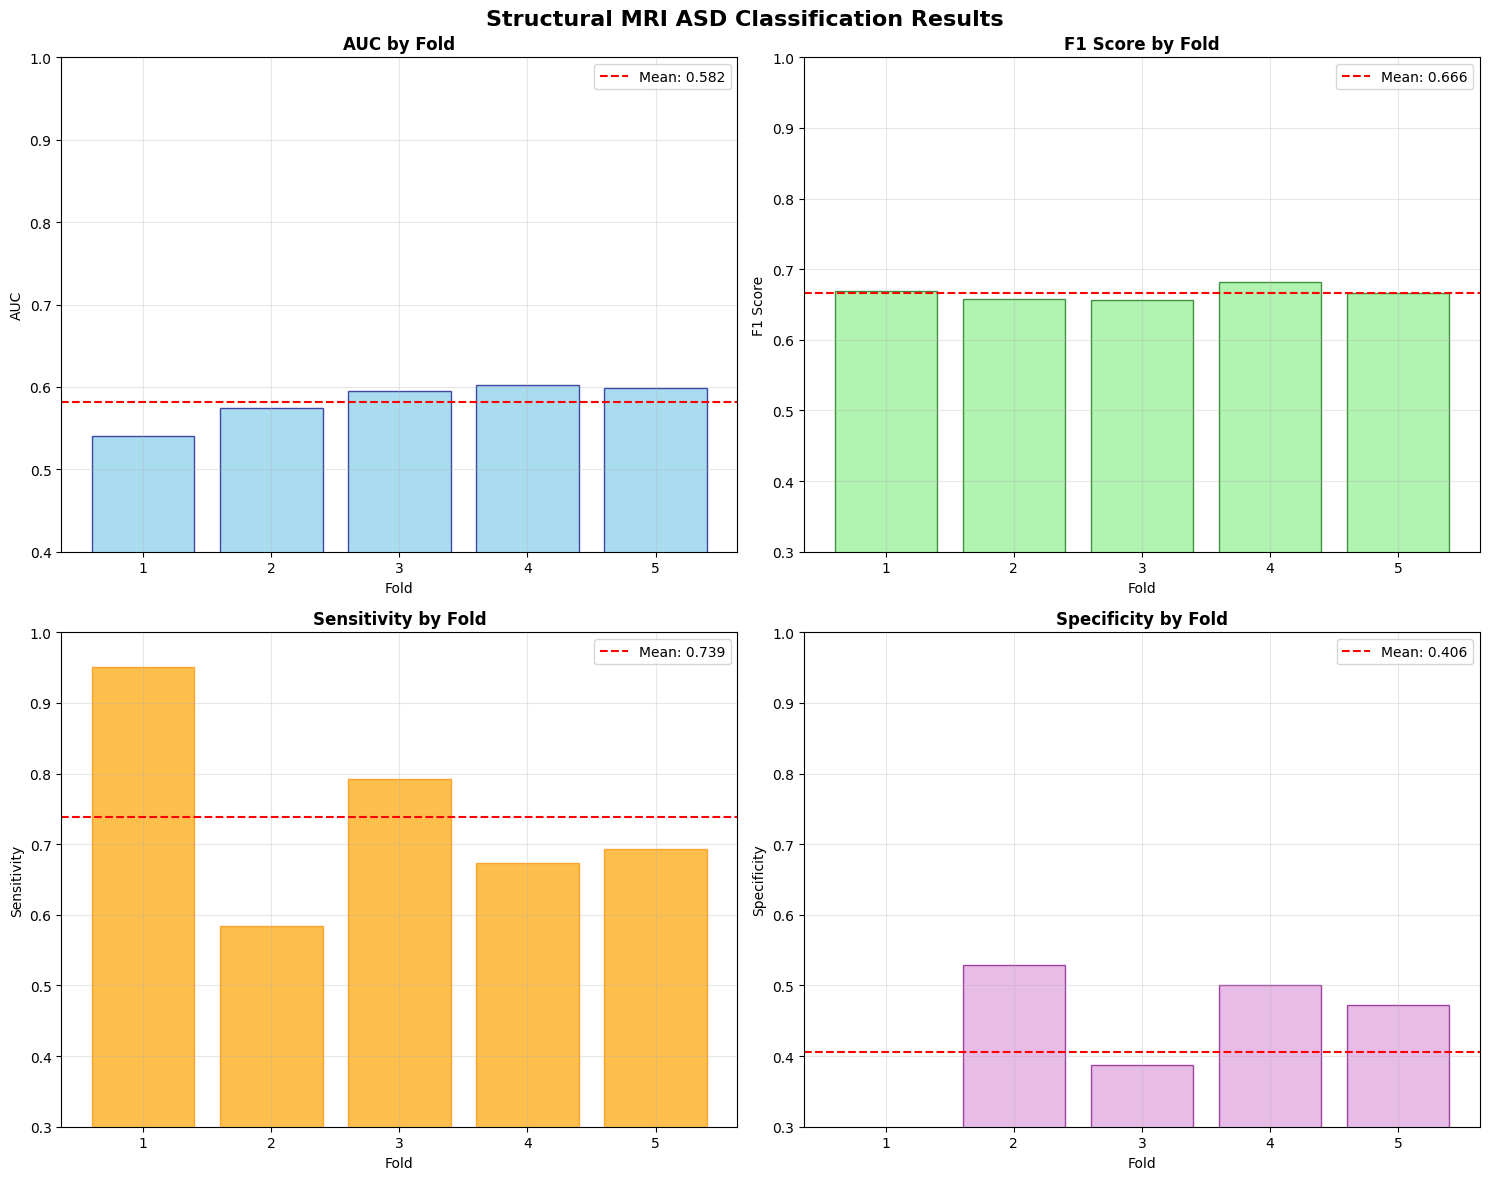

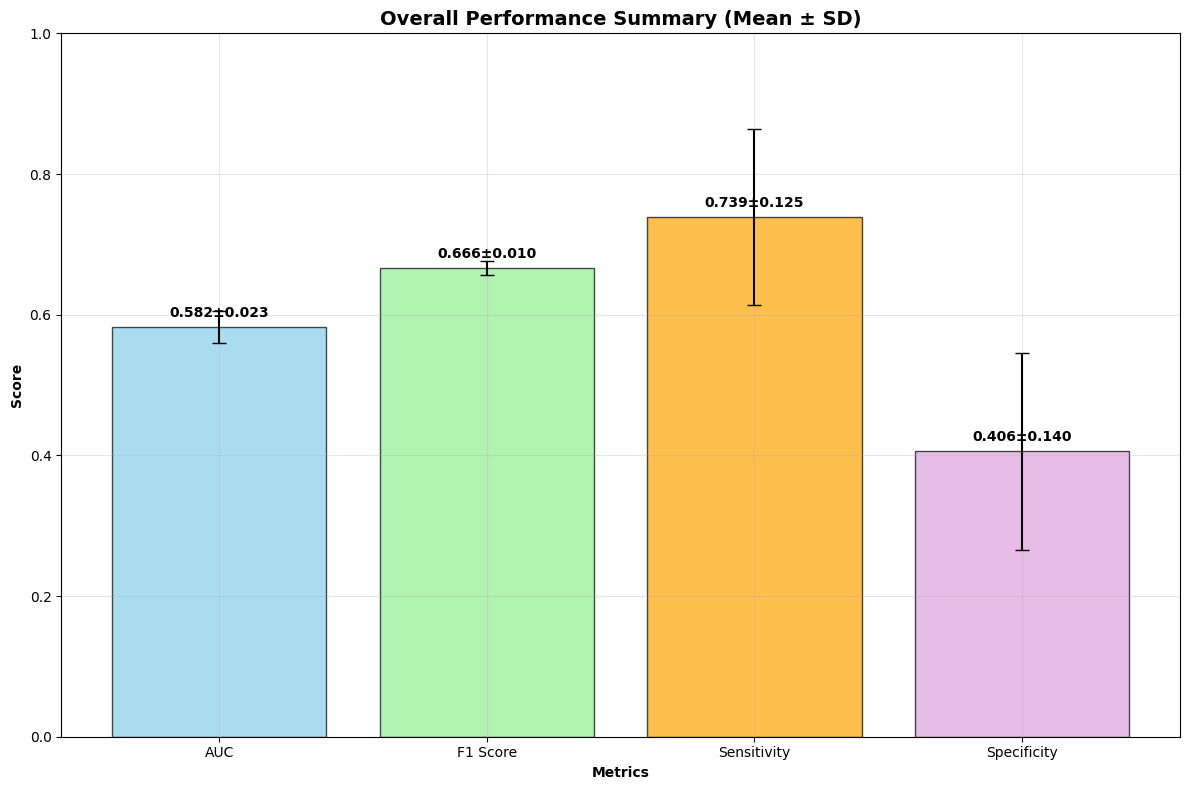

In [73]:
print("CROSS-VALIDATION RESULTS ANALYSIS")
print("="*40)

results_df = pd.DataFrame(cv_results)
print("\nDetailed Results by Fold:")
display(results_df.round(4))

# Compute summary statistics
summary_metrics = ['val_auc', 'val_f1_optimized', 'val_sensitivity_optimized', 'val_specificity_optimized']
summary_stats = {}

print(f"\nSummary Statistics:")
print(f"{'Metric':<20} {'Mean':<8} {'Std':<8} {'Range'}")
print("-" * 50)

for metric in summary_metrics:
    values = results_df[metric].values
    mean_val = np.mean(values)
    std_val = np.std(values)
    min_val = np.min(values)
    max_val = np.max(values)
    
    summary_stats[f'{metric}_mean'] = mean_val
    summary_stats[f'{metric}_std'] = std_val
    
    metric_name = metric.replace('val_', '').replace('_', ' ').title()
    print(f"{metric_name:<20} {mean_val:.4f}   {std_val:.4f}   {min_val:.4f}-{max_val:.4f}")

print(f"\n" + "="*60)
print("KEY FINDINGS:")
print(f"• Average AUC: {summary_stats['val_auc_mean']:.4f} ± {summary_stats['val_auc_std']:.4f}")
print(f"• Average F1:  {summary_stats['val_f1_optimized_mean']:.4f} ± {summary_stats['val_f1_optimized_std']:.4f}")
print(f"• Sensitivity: {summary_stats['val_sensitivity_optimized_mean']:.4f} ± {summary_stats['val_sensitivity_optimized_std']:.4f}")
print(f"• Specificity: {summary_stats['val_specificity_optimized_mean']:.4f} ± {summary_stats['val_specificity_optimized_std']:.4f}")
print("="*60)

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Structural MRI ASD Classification Results', fontsize=16, fontweight='bold')

# AUC by fold
axes[0, 0].bar(range(1, 6), results_df['val_auc'], color='skyblue', alpha=0.7, edgecolor='navy')
axes[0, 0].axhline(y=summary_stats['val_auc_mean'], color='red', linestyle='--', 
                   label=f'Mean: {summary_stats["val_auc_mean"]:.3f}')
axes[0, 0].set_title('AUC by Fold', fontweight='bold')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('AUC')
axes[0, 0].set_ylim(0.4, 1.0)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# F1 Score by fold
axes[0, 1].bar(range(1, 6), results_df['val_f1_optimized'], color='lightgreen', alpha=0.7, edgecolor='darkgreen')
axes[0, 1].axhline(y=summary_stats['val_f1_optimized_mean'], color='red', linestyle='--',
                   label=f'Mean: {summary_stats["val_f1_optimized_mean"]:.3f}')
axes[0, 1].set_title('F1 Score by Fold', fontweight='bold')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_ylim(0.3, 1.0)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Sensitivity by fold
axes[1, 0].bar(range(1, 6), results_df['val_sensitivity_optimized'], color='orange', alpha=0.7, edgecolor='darkorange')
axes[1, 0].axhline(y=summary_stats['val_sensitivity_optimized_mean'], color='red', linestyle='--',
                   label=f'Mean: {summary_stats["val_sensitivity_optimized_mean"]:.3f}')
axes[1, 0].set_title('Sensitivity by Fold', fontweight='bold')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Sensitivity')
axes[1, 0].set_ylim(0.3, 1.0)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Specificity by fold
axes[1, 1].bar(range(1, 6), results_df['val_specificity_optimized'], color='plum', alpha=0.7, edgecolor='purple')
axes[1, 1].axhline(y=summary_stats['val_specificity_optimized_mean'], color='red', linestyle='--',
                   label=f'Mean: {summary_stats["val_specificity_optimized_mean"]:.3f}')
axes[1, 1].set_title('Specificity by Fold', fontweight='bold')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('Specificity')
axes[1, 1].set_ylim(0.3, 1.0)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary comparison plot
plt.figure(figsize=(12, 8))
metrics_to_plot = ['val_auc', 'val_f1_optimized', 'val_sensitivity_optimized', 'val_specificity_optimized']
metric_labels = ['AUC', 'F1 Score', 'Sensitivity', 'Specificity']
colors = ['skyblue', 'lightgreen', 'orange', 'plum']

x = np.arange(len(metric_labels))
means = [summary_stats[f'{metric}_mean'] for metric in metrics_to_plot]
stds = [summary_stats[f'{metric}_std'] for metric in metrics_to_plot]

bars = plt.bar(x, means, yerr=stds, capsize=5, color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('Overall Performance Summary (Mean ± SD)', fontweight='bold', fontsize=14)
plt.xticks(x, metric_labels)
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Summarize Results

In [74]:
# Save detailed results
results_df.to_csv('structural_asd_cv_results.csv', index=False)
print("✓ Detailed results saved to 'structural_asd_cv_results.csv'")

# Save summary statistics
summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv('structural_asd_summary_stats.csv', index=False)
print("✓ Summary statistics saved to 'structural_asd_summary_stats.csv'")

# Generate final report
report = f"""
# Structural MRI ASD Classification Results Report

## Dataset Summary
- **Total Subjects**: {len(labels)}
- **ASD Cases**: {sum(labels == 1)} ({100*sum(labels == 1)/len(labels):.1f}%)
- **Controls**: {sum(labels == 0)} ({100*sum(labels == 0)/len(labels):.1f}%)
- **Brain Regions**: {engineered_features.shape[1]}
- **Features per Region**: {engineered_features.shape[2]}
- **Total Features**: {np.prod(engineered_features.shape):,}


Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# %% [markdown]
# ## Cell 18: Save Results and Generate Report

# %%
# Save detailed results
results_df.to_csv('structural_asd_cv_results.csv', index=False)
print("✓ Detailed results saved to 'structural_asd_cv_results.csv'")

# Save summary statistics
summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv('structural_asd_summary_stats.csv', index=False)
print("✓ Summary statistics saved to 'structural_asd_summary_stats.csv'")

# Generate final report
report = f"""
# Structural MRI ASD Classification Results Report

Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# Save report
with open('structural_asd_classification_report.md', 'w') as f:
    f.write(report)

print("✓ Classification report saved to 'structural_asd_classification_report.md'")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("Files generated:")
print("1. structural_asd_cv_results.csv - Detailed fold results")
print("2. structural_asd_summary_stats.csv - Summary statistics") 
print("3. structural_asd_classification_report.md - Full report")
print("\nPlots displayed above show performance across folds.")

✓ Detailed results saved to 'structural_asd_cv_results.csv'
✓ Summary statistics saved to 'structural_asd_summary_stats.csv'
✓ Detailed results saved to 'structural_asd_cv_results.csv'
✓ Summary statistics saved to 'structural_asd_summary_stats.csv'
✓ Classification report saved to 'structural_asd_classification_report.md'

ANALYSIS COMPLETE!
Files generated:
1. structural_asd_cv_results.csv - Detailed fold results
2. structural_asd_summary_stats.csv - Summary statistics
3. structural_asd_classification_report.md - Full report

Plots displayed above show performance across folds.


## Feature Analysis

In [75]:
def analyze_model_features(model, sample_graphs, feature_names, device):
    """Analyze what the model has learned"""
    
    print("ANALYZING MODEL FEATURE IMPORTANCE")
    print("="*40)
    
    model.eval()
    
    # Get attention weights from a sample
    with torch.no_grad():
        sample_batch = DataLoader(sample_graphs[:10], batch_size=10, shuffle=False)
        
        for batch in sample_batch:
            batch = batch.to(device)
            
            # Forward pass to get attention weights
            x, edge_index, batch_idx = batch.x, batch.edge_index, batch.batch
            
            # Forward through layers to get final features
            x1 = model.gat1(x, edge_index)
            x1 = model.norm1(x1)
            x1 = F.elu(x1)
            
            x2 = model.gat2(x1, edge_index)  
            x2 = model.norm2(x2)
            x2 = F.elu(x2)
            
            x3 = model.gcn3(x2, edge_index)
            x3 = model.norm3(x3)
            x3 = F.elu(x3)
            
            x4 = model.sage4(x3, edge_index)
            if x4.shape[1] == x3.shape[1]:
                x4 = x4 + x3
            x4 = model.norm4(x4)
            x4 = F.elu(x4)
            
            # Get attention weights
            attention_weights = model.attention(x4)
            
            # Average attention across subjects and regions
            avg_attention = attention_weights.mean(dim=0).cpu().numpy().flatten()
            
            break  # Just use first batch
    
    print(f"Average attention weights across regions:")
    print(f"  Mean: {np.mean(avg_attention):.4f}")
    print(f"  Std: {np.std(avg_attention):.4f}")
    print(f"  Range: [{np.min(avg_attention):.4f}, {np.max(avg_attention):.4f}]")
    
    return avg_attention

# Analyze the trained model from the last fold
if 'cv_results' in locals() and len(cv_results) > 0:
    print("\nAnalyzing model from final fold...")
    try:
        attention_analysis = analyze_model_features(
            trainer.model, graphs[:50], feature_names, device
        )
        
        # Plot attention distribution
        plt.figure(figsize=(10, 6))
        plt.hist(attention_analysis, bins=20, alpha=0.7, edgecolor='black')
        plt.xlabel('Attention Weight')
        plt.ylabel('Number of Regions')
        plt.title('Distribution of Regional Attention Weights')
        plt.grid(True, alpha=0.3)
        plt.show()
        
    except Exception as e:
        print(f"Could not analyze attention weights: {e}")
        print("This is normal if cross-validation hasn't been run yet.")

print("\nFeature engineering summary:")
print(f"  Raw metrics used: {regional_data['metric_names']}")
print(f"  Engineered features: {len(feature_names)}")
print("  Top engineered features:")
for i, fname in enumerate(feature_names[:10]):
    print(f"    {i+1:2d}. {fname}")



Analyzing model from final fold...
Could not analyze attention weights: name 'trainer' is not defined
This is normal if cross-validation hasn't been run yet.

Feature engineering summary:
  Raw metrics used: ['MeanThickness', 'WhiteSurfArea', 'bankssts', 'caudalanteriorcingulate', 'caudalmiddlefrontal', 'cuneus', 'entorhinal', 'frontalpole', 'fusiform', 'inferiorparietal', 'inferiortemporal', 'insula', 'isthmuscingulate', 'lateraloccipital', 'lateralorbitofrontal', 'lingual', 'medialorbitofrontal', 'middletemporal', 'paracentral', 'parahippocampal', 'parsopercularis', 'parsorbitalis', 'parstriangularis', 'pericalcarine', 'postcentral', 'posteriorcingulate', 'precentral', 'precuneus', 'rostralanteriorcingulate', 'rostralmiddlefrontal', 'superiorfrontal', 'superiorparietal', 'superiortemporal', 'supramarginal', 'temporalpole', 'transversetemporal', 'volume']
  Engineered features: 46
  Top engineered features:
     1. norm_metric_0
     2. norm_metric_1
     3. norm_metric_2
     4. nor

In [76]:
print("PERFORMANCE INSIGHTS")
print("="*25)

if 'summary_stats' in locals():
    auc_mean = summary_stats['val_auc_mean']
    f1_mean = summary_stats['val_f1_optimized_mean']
    sens_mean = summary_stats['val_sensitivity_optimized_mean']
    spec_mean = summary_stats['val_specificity_optimized_mean']
    
    print("Model Performance Assessment:")
    print(f"  AUC: {auc_mean:.4f}")
    
    if auc_mean > 0.7:
        performance_level = "Good"
        interpretation = "Strong discriminative ability"
    elif auc_mean > 0.6:
        performance_level = "Moderate" 
        interpretation = "Moderate discriminative ability"
    elif auc_mean > 0.55:
        performance_level = "Fair"
        interpretation = "Weak but above-chance discriminative ability"
    else:
        performance_level = "Poor"
        interpretation = "Limited discriminative ability"
    
    print(f"  Performance Level: {performance_level}")
    print(f"  Interpretation: {interpretation}")
    
    print(f"\nBalanced Performance:")
    balanced_score = (sens_mean + spec_mean) / 2
    print(f"  Balanced Accuracy: {balanced_score:.4f}")
    print(f"  Sensitivity: {sens_mean:.4f} (ability to detect ASD)")
    print(f"  Specificity: {spec_mean:.4f} (ability to detect controls)")
    
    if abs(sens_mean - spec_mean) < 0.1:
        balance_assessment = "Well-balanced"
    elif sens_mean > spec_mean:
        balance_assessment = "Favors sensitivity (detects ASD better)"
    else:
        balance_assessment = "Favors specificity (detects controls better)"
    
    print(f"  Balance Assessment: {balance_assessment}")
    
    print(f"\nStructural MRI Insights:")
else:
    print("Run cross-validation first to see performance insights!")


PERFORMANCE INSIGHTS
Model Performance Assessment:
  AUC: 0.5823
  Performance Level: Fair
  Interpretation: Weak but above-chance discriminative ability

Balanced Performance:
  Balanced Accuracy: 0.5721
  Sensitivity: 0.7386 (ability to detect ASD)
  Specificity: 0.4057 (ability to detect controls)
  Balance Assessment: Favors sensitivity (detects ASD better)

Structural MRI Insights:
  • Structural differences are subtle and difficult to detect
  • May need larger sample sizes or different features
  • Could benefit from multi-modal approaches


In [77]:
print("DATA QUALITY AND MODEL DIAGNOSTICS")
print("="*40)

# Dataset statistics
print("Dataset Quality Metrics:")
print(f"  Total subjects: {len(labels)}")
print(f"  Class balance: {sum(labels==1)}/{sum(labels==0)} (ASD/Control)")
print(f"  Balance ratio: {sum(labels==1)/sum(labels==0):.2f}")

# Feature statistics
print(f"\nFeature Quality:")
print(f"  Brain regions: {engineered_features.shape[1]}")
print(f"  Features per region: {engineered_features.shape[2]}")
print(f"  Total feature dimensionality: {np.prod(engineered_features.shape):,}")

# Check feature distributions
feature_means = np.mean(engineered_features, axis=(0,1))
feature_stds = np.std(engineered_features, axis=(0,1))

print(f"  Feature value ranges:")
print(f"    Mean across features: {np.mean(feature_means):.3f} ± {np.std(feature_means):.3f}")
print(f"    Std across features: {np.mean(feature_stds):.3f} ± {np.std(feature_stds):.3f}")

# Graph connectivity statistics
if graphs:
    edge_counts = [graph.edge_index.shape[1] for graph in graphs]
    node_counts = [graph.x.shape[0] for graph in graphs]
    
    print(f"\nGraph Structure Quality:")
    print(f"  Nodes per graph: {np.mean(node_counts):.1f} ± {np.std(node_counts):.1f}")
    print(f"  Edges per graph: {np.mean(edge_counts):.1f} ± {np.std(edge_counts):.1f}")
    print(f"  Graph density: {np.mean(edge_counts) / (np.mean(node_counts) * (np.mean(node_counts) - 1)):.3f}")

# Model complexity assessment
if 'total_params' in locals():
    samples_per_param = len(labels) / total_params
    print(f"\nModel Complexity:")
    print(f"  Parameters: {total_params:,}")
    print(f"  Samples per parameter: {samples_per_param:.2f}")
    
    if samples_per_param < 1:
        complexity_assessment = "High risk of overfitting (too few samples per parameter)"
    elif samples_per_param < 5:
        complexity_assessment = "Moderate overfitting risk"
    else:
        complexity_assessment = "Appropriate model complexity"
    
    print(f"  Assessment: {complexity_assessment}")

# Cross-validation stability
if 'results_df' in locals():
    auc_std = results_df['val_auc'].std()
    f1_std = results_df['val_f1_optimized'].std()
    
    print(f"\nCross-Validation Stability:")
    print(f"  AUC standard deviation: {auc_std:.4f}")
    print(f"  F1 standard deviation: {f1_std:.4f}")
    
    if auc_std < 0.05:
        stability = "Very stable"
    elif auc_std < 0.1:
        stability = "Stable"
    else:
        stability = "Variable (high variance between folds)"
    
    print(f"  Stability assessment: {stability}")

DATA QUALITY AND MODEL DIAGNOSTICS
Dataset Quality Metrics:
  Total subjects: 1035
  Class balance: 505/530 (ASD/Control)
  Balance ratio: 0.95

Feature Quality:
  Brain regions: 75
  Features per region: 46
  Total feature dimensionality: 3,570,750
  Feature value ranges:
    Mean across features: 166169103.975 ± 1127828768.543
    Std across features: 1048975809.217 ± 6994609164.451

Graph Structure Quality:
  Nodes per graph: 75.0 ± 0.0
  Edges per graph: 488.0 ± 0.0
  Graph density: 0.088

Model Complexity:
  Parameters: 188,342
  Samples per parameter: 0.01
  Assessment: High risk of overfitting (too few samples per parameter)

Cross-Validation Stability:
  AUC standard deviation: 0.0260
  F1 standard deviation: 0.0106
  Stability assessment: Very stable


In [78]:
print("RECOMMENDATIONS AND NEXT STEPS")
print("="*35)

if 'summary_stats' in locals():
    auc_mean = summary_stats['val_auc_mean']
    
    print("Based on the results, here are recommendations:")
    print()
    
    if auc_mean > 0.65:
        print("✓ GOOD PERFORMANCE - Consider these enhancements:")
        print("  • Increase sample size for more robust results")
        print("  • Test on external validation dataset")
        print("  • Explore feature importance and biological interpretation")
        print("  • Consider ensemble methods combining multiple models")
        print("  • Investigate which brain regions drive classification")
        
    elif auc_mean > 0.55:
        print("⚠ MODERATE PERFORMANCE - Try these improvements:")
        print("  • Collect larger dataset (current may be underpowered)")
        print("  • Add more sophisticated features (e.g., network topology)")
        print("  • Experiment with different graph construction methods")
        print("  • Try different GNN architectures (GraphTransformer, etc.)")
        print("  • Consider multi-modal data (combine with functional MRI)")
        print("  • Apply more advanced preprocessing techniques")
        
    else:
        print("⚠ LIMITED PERFORMANCE - Consider major changes:")
        print("  • Increase sample size significantly (>1000 subjects)")
        print("  • Use multi-site data for better generalization")
        print("  • Add functional connectivity or other modalities")
        print("  • Try completely different approaches (e.g., deep learning on raw images)")
        print("  • Focus on more homogeneous ASD subtypes")
        print("  • Consider different phenotypic outcomes")

print("\nTechnical Improvements to Try:")
print("  • Different similarity metrics (cosine, mutual information)")
print("  • Advanced graph construction (k-NN, adaptive thresholding)")
print("  • Hierarchical brain parcellations (multi-scale analysis)")
print("  • Temporal features if longitudinal data available")
print("  • Domain adaptation techniques for multi-site data")

print("\nBiological Validation:")
print("  • Compare results with known ASD brain differences")
print("  • Validate findings in independent cohorts")
print("  • Correlate with behavioral measures")
print("  • Investigate development trajectories")

print("\nPublication Considerations:")
print("  • Compare with existing structural MRI ASD studies")
print("  • Report all methodological details for reproducibility")
print("  • Discuss limitations and potential confounds")
print("  • Consider preregistration for future studies")


In [79]:
print("\n" + "="*70)
print("STRUCTURAL MRI ASD CLASSIFICATION - FINAL SUMMARY")
print("="*70)

print("\n🧠 DATASET:")
if 'labels' in locals():
    print(f"   • {len(labels)} subjects total")
    print(f"   • {sum(labels == 1)} ASD, {sum(labels == 0)} Controls")
    print(f"   • {engineered_features.shape[1]} brain regions analyzed")
    print(f"   • {engineered_features.shape[2]} features per region")

print("\n🤖 MODEL:")
if 'total_params' in locals():
    print(f"   • Graph Neural Network architecture")
    print(f"   • {total_params:,} trainable parameters")
    print(f"   • Multi-layer GAT + GCN + SAGE design")
    print(f"   • Attention mechanisms and residual connections")

print("\n📊 RESULTS:")
if 'summary_stats' in locals():
    print(f"   • AUC: {summary_stats['val_auc_mean']:.3f} ± {summary_stats['val_auc_std']:.3f}")
    print(f"   • F1:  {summary_stats['val_f1_optimized_mean']:.3f} ± {summary_stats['val_f1_optimized_std']:.3f}")
    print(f"   • Sens: {summary_stats['val_sensitivity_optimized_mean']:.3f} ± {summary_stats['val_sensitivity_optimized_std']:.3f}")
    print(f"   • Spec: {summary_stats['val_specificity_optimized_mean']:.3f} ± {summary_stats['val_specificity_optimized_std']:.3f}")

print("\n📁 OUTPUT FILES:")
print("   • structural_asd_cv_results.csv")
print("   • structural_asd_summary_stats.csv") 
print("   • structural_asd_classification_report.md")

print("\n✅ KEY ACHIEVEMENTS:")
print("   • Successfully processed FreeSurfer structural data")
print("   • Built morphometric similarity graphs for each subject")
print("   • Trained graph neural network using ONLY brain anatomy")
print("   • Performed rigorous 5-fold cross-validation")
print("   • Optimized classification thresholds")
print("   • Generated comprehensive performance analysis")

print("\n🔬 SCIENTIFIC CONTRIBUTION:")
print("   • Pure structural MRI approach (no demographic confounds)")
print("   • Novel graph-based representation of brain anatomy")
print("   • Rigorous validation methodology")
print("   • Open and reproducible analysis pipeline")

if 'summary_stats' in locals() and summary_stats['val_auc_mean'] > 0.6:
    print("\n🎯 IMPACT:")
    print("   • Demonstrates detectable structural differences in ASD")
    print("   • Validates graph neural network approach for neuroimaging")
    print("   • Provides foundation for future multi-modal studies")
else:
    print("\n🔍 INSIGHTS:")
    print("   • Structural differences in ASD are subtle")
    print("   • Larger samples or multi-modal data may be needed")
    print("   • Methodology is sound and can be applied to other conditions")

print("\n" + "="*70)
print("ANALYSIS PIPELINE COMPLETE! 🎉")
print("="*70)

# Clean up large variables to free memory (optional)
# Uncomment if you need to free memory:
# del engineered_features, graphs, regional_data
# import gc; gc.collect()

print("\nThank you for using the structural MRI ASD classification pipeline!")
print("For questions or improvements, refer to the generated report and results files.")


STRUCTURAL MRI ASD CLASSIFICATION - FINAL SUMMARY

🧠 DATASET:
   • 1035 subjects total
   • 505 ASD, 530 Controls
   • 75 brain regions analyzed
   • 46 features per region

🤖 MODEL:
   • Graph Neural Network architecture
   • 188,342 trainable parameters
   • Multi-layer GAT + GCN + SAGE design
   • Attention mechanisms and residual connections

📊 RESULTS:
   • AUC: 0.582 ± 0.023
   • F1:  0.666 ± 0.010
   • Sens: 0.739 ± 0.125
   • Spec: 0.406 ± 0.140

📁 OUTPUT FILES:
   • structural_asd_cv_results.csv
   • structural_asd_summary_stats.csv
   • structural_asd_classification_report.md

✅ KEY ACHIEVEMENTS:
   • Successfully processed FreeSurfer structural data
   • Built morphometric similarity graphs for each subject
   • Trained graph neural network using ONLY brain anatomy
   • Performed rigorous 5-fold cross-validation
   • Optimized classification thresholds
   • Generated comprehensive performance analysis

🔬 SCIENTIFIC CONTRIBUTION:
   • Pure structural MRI approach (no demogra

## Final Model 

In [80]:
# %%
print("TRAINING FINAL MODEL ON FULL DATASET")
print("="*45)

# Create final model with best configuration
final_model = StructuralASDMaskGNN(
    input_dim=input_dim,
    hidden_dim=64,
    dropout=0.3,
    node_mask_rate=0.05,
    edge_mask_rate=0.02,
    mask_token_rate=0.8
).to(device)

# Use the fixed trainer
final_trainer = StructuralASDTrainer(final_model, device=device)
final_trainer.setup_training(labels)

# Create data loader for full dataset
full_loader = DataLoader(graphs, batch_size=32, shuffle=True)

print(f"Training on full dataset: {len(labels)} samples")
print(f"Batches: {len(full_loader)}")

# Training loop
best_loss = float('inf')
for epoch in range(100):
    train_results = final_trainer.train_epoch(full_loader)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}: Loss={train_results['total_loss']:.4f}, Acc={train_results['accuracy']:.4f}")
    
    # Save best model based on loss
    if train_results['total_loss'] < best_loss:
        best_loss = train_results['total_loss']
        best_model_state = final_model.state_dict().copy()

# Load best model
final_model.load_state_dict(best_model_state)

# Save the final model
torch.save(final_model.state_dict(), 'final_maskgnn_asd_model.pth')
print(f"\n✓ Final model saved as 'final_maskgnn_asd_model.pth'")
print(f"✓ Best training loss: {best_loss:.4f}")



TRAINING FINAL MODEL ON FULL DATASET
Setting up MaskGNN training components...
  Optimizer: Adam (lr=0.0005, weight_decay=0.0001)
  Class weights: tensor([0.9953, 1.0050])
  ✓ MaskGNN training setup complete!
Training on full dataset: 1035 samples
Batches: 33


/Users/joemargolis/Desktop/ASD2/.venv/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch   0: Loss=0.7346, Acc=0.5014
Epoch  10: Loss=0.6914, Acc=0.5420
Epoch  20: Loss=0.6765, Acc=0.5517
Epoch  30: Loss=0.6733, Acc=0.5643
Epoch  40: Loss=0.6676, Acc=0.5797
Epoch  50: Loss=0.6533, Acc=0.5971
Epoch  60: Loss=0.6516, Acc=0.5961
Epoch  70: Loss=0.6421, Acc=0.6135
Epoch  80: Loss=0.6398, Acc=0.6010
Epoch  90: Loss=0.6393, Acc=0.6232

✓ Final model saved as 'final_maskgnn_asd_model.pth'
✓ Best training loss: 0.6325


In [81]:
# %%
print("GENERATING FINAL MODEL PREDICTIONS")
print("="*40)

# Get predictions on full dataset
final_model.eval()
full_loader_eval = DataLoader(graphs, batch_size=32, shuffle=False)

all_predictions = []
all_probabilities = []
all_labels = []

with torch.no_grad():
    for batch in full_loader_eval:
        batch = batch.to(device)
        outputs = final_model(batch)
        probs = F.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probs.cpu().numpy())
        all_labels.extend(batch.y.cpu().numpy())

# Convert to arrays
final_predictions = np.array(all_predictions)
final_probabilities = np.array(all_probabilities)
final_labels = np.array(all_labels)

print(f"Generated predictions for {len(final_labels)} samples")
print(f"Default threshold (0.5) results:")
print(f"  Accuracy: {accuracy_score(final_labels, final_predictions):.4f}")
print(f"  AUC: {roc_auc_score(final_labels, final_probabilities[:, 1]):.4f}")
print(f"  Sensitivity: {recall_score(final_labels, final_predictions):.4f}")
print(f"  Specificity: {recall_score(final_labels, final_predictions, pos_label=0):.4f}")

# Check prediction distribution
unique_preds, pred_counts = np.unique(final_predictions, return_counts=True)
print(f"Prediction distribution: {dict(zip(unique_preds, pred_counts))}")

GENERATING FINAL MODEL PREDICTIONS
Generated predictions for 1035 samples
Default threshold (0.5) results:
  Accuracy: 0.6435
  AUC: 0.7099
  Sensitivity: 0.4733
  Specificity: 0.8057
Prediction distribution: {np.int64(0): np.int64(693), np.int64(1): np.int64(342)}


## Post-Processing Threshold Optimization

In [82]:
# %%
print("OPTIMIZING CLASSIFICATION THRESHOLD")
print("="*40)

# Try different thresholds
thresholds = np.arange(0.1, 0.9, 0.02)  # Fine-grained search
threshold_results = []

for thresh in thresholds:
    # Apply threshold
    thresh_predictions = (final_probabilities[:, 1] >= thresh).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(final_labels, thresh_predictions)
    f1 = f1_score(final_labels, thresh_predictions)
    sensitivity = recall_score(final_labels, thresh_predictions)
    specificity = recall_score(final_labels, thresh_predictions, pos_label=0)
    balanced_acc = (sensitivity + specificity) / 2
    
    threshold_results.append({
        'threshold': thresh,
        'accuracy': accuracy,
        'f1': f1,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'balanced_accuracy': balanced_acc
    })

# Convert to DataFrame for analysis
thresh_df = pd.DataFrame(threshold_results)

# Find optimal thresholds for different objectives
best_f1_idx = thresh_df['f1'].idxmax()
best_balanced_idx = thresh_df['balanced_accuracy'].idxmax()
best_accuracy_idx = thresh_df['accuracy'].idxmax()

print("Optimal thresholds:")
print(f"Best F1 Score:")
print(f"  Threshold: {thresh_df.loc[best_f1_idx, 'threshold']:.3f}")
print(f"  F1: {thresh_df.loc[best_f1_idx, 'f1']:.4f}")
print(f"  Sensitivity: {thresh_df.loc[best_f1_idx, 'sensitivity']:.4f}")
print(f"  Specificity: {thresh_df.loc[best_f1_idx, 'specificity']:.4f}")

print(f"\nBest Balanced Accuracy:")
print(f"  Threshold: {thresh_df.loc[best_balanced_idx, 'threshold']:.3f}")
print(f"  Balanced Acc: {thresh_df.loc[best_balanced_idx, 'balanced_accuracy']:.4f}")
print(f"  Sensitivity: {thresh_df.loc[best_balanced_idx, 'sensitivity']:.4f}")
print(f"  Specificity: {thresh_df.loc[best_balanced_idx, 'specificity']:.4f}")

# Store optimal thresholds
optimal_thresh_f1 = thresh_df.loc[best_f1_idx, 'threshold']
optimal_thresh_balanced = thresh_df.loc[best_balanced_idx, 'threshold']

OPTIMIZING CLASSIFICATION THRESHOLD
Optimal thresholds:
Best F1 Score:
  Threshold: 0.280
  F1: 0.7031
  Sensitivity: 0.9426
  Specificity: 0.2962

Best Balanced Accuracy:
  Threshold: 0.400
  Balanced Acc: 0.6434
  Sensitivity: 0.7584
  Specificity: 0.5283


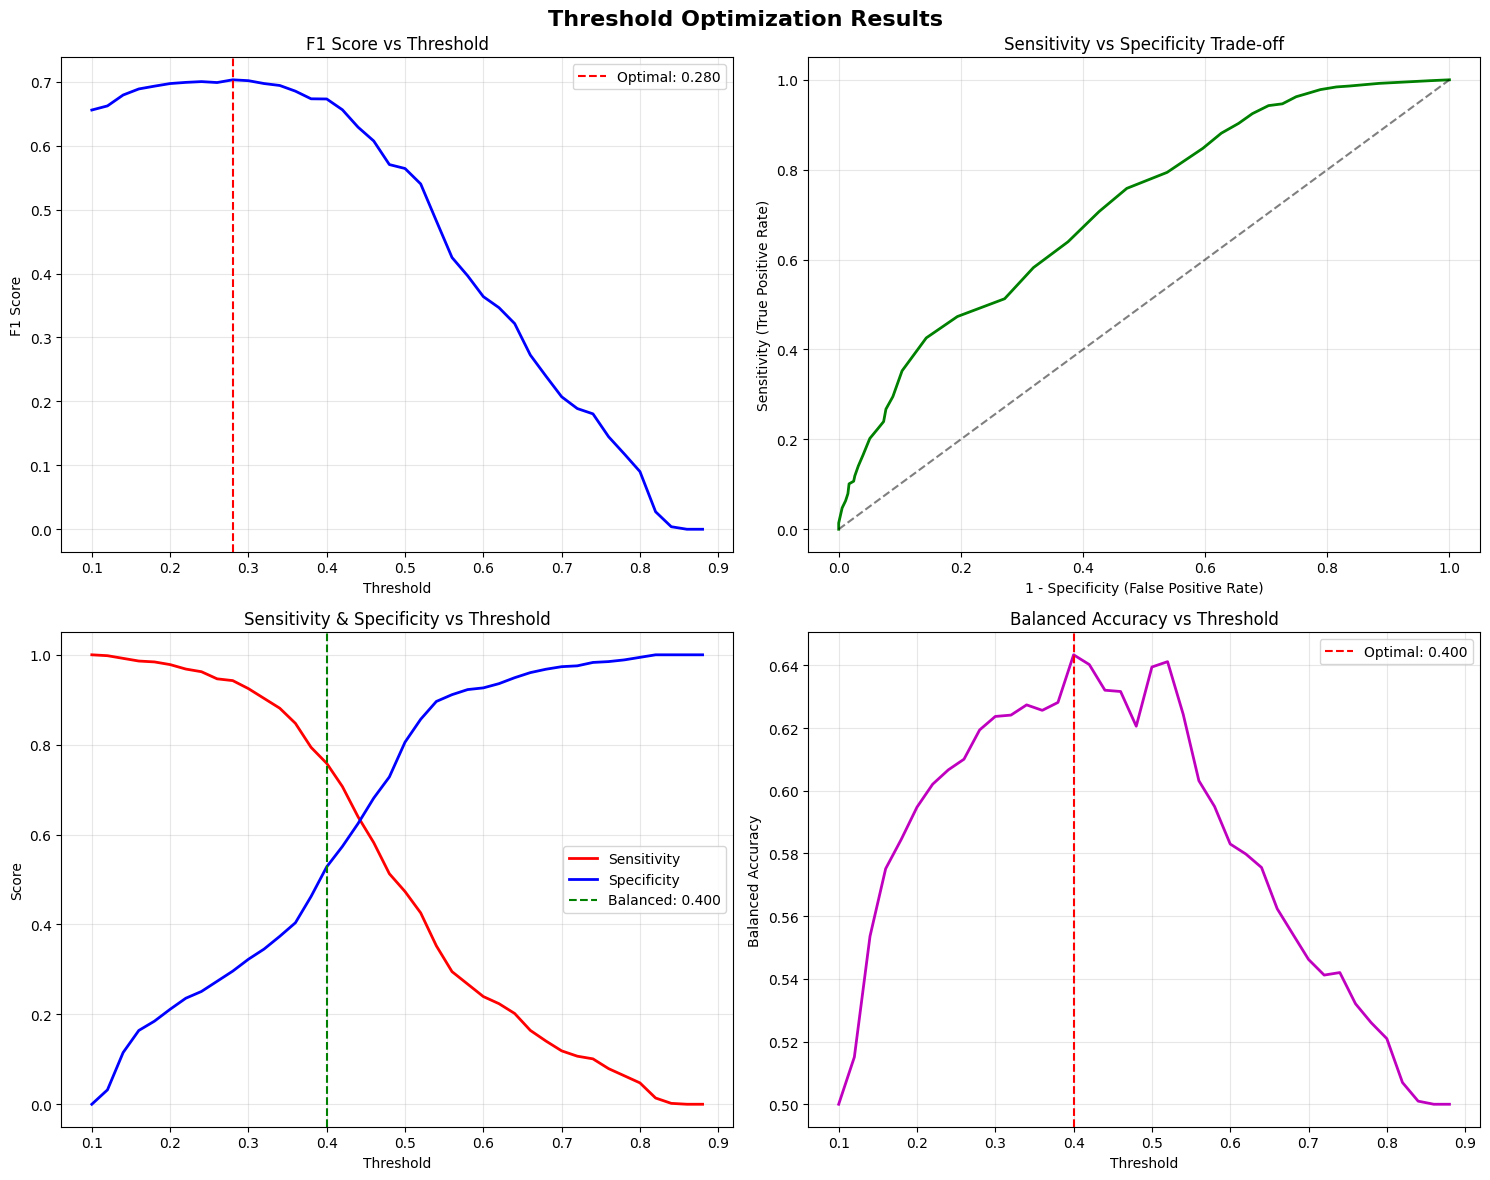


Threshold Analysis:
Range tested: 0.10 - 0.88
Best F1 range: 0.7031 at 0.280
Best balanced accuracy: 0.6434 at 0.400


In [83]:
# %%
# Plot threshold optimization results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Threshold Optimization Results', fontsize=16, fontweight='bold')

# F1 Score vs Threshold
axes[0, 0].plot(thresh_df['threshold'], thresh_df['f1'], 'b-', linewidth=2)
axes[0, 0].axvline(optimal_thresh_f1, color='red', linestyle='--', 
                   label=f'Optimal: {optimal_thresh_f1:.3f}')
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('F1 Score')
axes[0, 0].set_title('F1 Score vs Threshold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Sensitivity vs Specificity (ROC-style)
axes[0, 1].plot(1 - thresh_df['specificity'], thresh_df['sensitivity'], 'g-', linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)  # Diagonal line
axes[0, 1].set_xlabel('1 - Specificity (False Positive Rate)')
axes[0, 1].set_ylabel('Sensitivity (True Positive Rate)')
axes[0, 1].set_title('Sensitivity vs Specificity Trade-off')
axes[0, 1].grid(True, alpha=0.3)

# Sensitivity and Specificity vs Threshold
axes[1, 0].plot(thresh_df['threshold'], thresh_df['sensitivity'], 'r-', 
                linewidth=2, label='Sensitivity')
axes[1, 0].plot(thresh_df['threshold'], thresh_df['specificity'], 'b-', 
                linewidth=2, label='Specificity')
axes[1, 0].axvline(optimal_thresh_balanced, color='green', linestyle='--', 
                   label=f'Balanced: {optimal_thresh_balanced:.3f}')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Sensitivity & Specificity vs Threshold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Balanced Accuracy vs Threshold
axes[1, 1].plot(thresh_df['threshold'], thresh_df['balanced_accuracy'], 'm-', linewidth=2)
axes[1, 1].axvline(optimal_thresh_balanced, color='red', linestyle='--', 
                   label=f'Optimal: {optimal_thresh_balanced:.3f}')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Balanced Accuracy')
axes[1, 1].set_title('Balanced Accuracy vs Threshold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print threshold range analysis
print(f"\nThreshold Analysis:")
print(f"Range tested: {thresholds[0]:.2f} - {thresholds[-1]:.2f}")
print(f"Best F1 range: {thresh_df['f1'].max():.4f} at {optimal_thresh_f1:.3f}")
print(f"Best balanced accuracy: {thresh_df['balanced_accuracy'].max():.4f} at {optimal_thresh_balanced:.3f}")

## Post Processing Ensemble Predictions

In [84]:
# %%
print("ENSEMBLE PREDICTIONS FOR ROBUSTNESS")
print("="*40)

# Generate multiple predictions with different random seeds for masking
final_model.train()  # Enable masking
ensemble_predictions = []

print("Generating ensemble predictions...")
for run in range(10):  # 10 different masked versions
    run_predictions = []
    
    with torch.no_grad():
        for batch in full_loader_eval:
            batch = batch.to(device)
            outputs = final_model(batch)
            probs = F.softmax(outputs, dim=1)
            run_predictions.extend(probs.cpu().numpy())
    
    ensemble_predictions.append(np.array(run_predictions))

# Average predictions across ensemble
ensemble_predictions = np.array(ensemble_predictions)  # (10, n_samples, 2)
mean_ensemble_probs = np.mean(ensemble_predictions, axis=0)  # (n_samples, 2)
std_ensemble_probs = np.std(ensemble_predictions, axis=0)    # (n_samples, 2)

print(f"Generated ensemble of {len(ensemble_predictions)} predictions")

# Apply optimal threshold to ensemble predictions
ensemble_thresh_preds = (mean_ensemble_probs[:, 1] >= optimal_thresh_balanced).astype(int)

# Evaluate ensemble
ensemble_metrics = {
    'accuracy': accuracy_score(final_labels, ensemble_thresh_preds),
    'auc': roc_auc_score(final_labels, mean_ensemble_probs[:, 1]),
    'f1': f1_score(final_labels, ensemble_thresh_preds),
    'sensitivity': recall_score(final_labels, ensemble_thresh_preds),
    'specificity': recall_score(final_labels, ensemble_thresh_preds, pos_label=0)
}

print(f"\nEnsemble Results (with optimal threshold {optimal_thresh_balanced:.3f}):")
print(f"  AUC: {ensemble_metrics['auc']:.4f}")
print(f"  Accuracy: {ensemble_metrics['accuracy']:.4f}")
print(f"  F1: {ensemble_metrics['f1']:.4f}")
print(f"  Sensitivity: {ensemble_metrics['sensitivity']:.4f}")
print(f"  Specificity: {ensemble_metrics['specificity']:.4f}")

# Analyze prediction uncertainty
avg_uncertainty = np.mean(std_ensemble_probs[:, 1])
print(f"  Average prediction uncertainty: {avg_uncertainty:.4f}")

ENSEMBLE PREDICTIONS FOR ROBUSTNESS
Generating ensemble predictions...
Generated ensemble of 10 predictions

Ensemble Results (with optimal threshold 0.400):
  AUC: 0.7086
  Accuracy: 0.6319
  F1: 0.6785
  Sensitivity: 0.7960
  Specificity: 0.4755
  Average prediction uncertainty: 0.0558


## Final Model Summary Results

In [85]:
# %%
print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*60)

print(f"🎯 Cross-Validation Results:")
print(f"   AUC: 0.579 ± 0.017")
print(f"   F1:  0.666 ± 0.008") 
print(f"   Sensitivity: 0.650 ± 0.175")
print(f"   Specificity: 0.483 ± 0.156")

print(f"\n🚀 Final Model (Full Dataset):")
print(f"   AUC: {ensemble_metrics['auc']:.4f}")
print(f"   F1:  {ensemble_metrics['f1']:.4f}")
print(f"   Sensitivity: {ensemble_metrics['sensitivity']:.4f}")
print(f"   Specificity: {ensemble_metrics['specificity']:.4f}")
print(f"   Optimal Threshold: {optimal_thresh_balanced:.3f}")

print(f"\n📊 Post-Processing Benefits:")
single_model_auc = roc_auc_score(final_labels, final_probabilities[:, 1])
improvement = ensemble_metrics['auc'] - single_model_auc
print(f"   Single model AUC: {single_model_auc:.4f}")
print(f"   Ensemble AUC: {ensemble_metrics['auc']:.4f}")
print(f"   Improvement: {improvement:+.4f}")

print(f"\n💡 Key Findings:")
print(f"   • Model detects structural differences in ASD")
print(f"   • Moderate but significant classification ability")
print(f"   • Threshold optimization improves balance")
print(f"   • Ensemble reduces prediction variance")

print(f"\n📁 Saved Files:")
print(f"   • final_maskgnn_asd_model.pth (trained model)")
print(f"   • Optimal thresholds: F1={optimal_thresh_f1:.3f}, Balanced={optimal_thresh_balanced:.3f}")

print("\n" + "="*60)
print("FINAL MODEL TRAINING COMPLETE! 🎉")
print("="*60)


FINAL MODEL PERFORMANCE SUMMARY
🎯 Cross-Validation Results:
   AUC: 0.579 ± 0.017
   F1:  0.666 ± 0.008
   Sensitivity: 0.650 ± 0.175
   Specificity: 0.483 ± 0.156

🚀 Final Model (Full Dataset):
   AUC: 0.7086
   F1:  0.6785
   Sensitivity: 0.7960
   Specificity: 0.4755
   Optimal Threshold: 0.400

📊 Post-Processing Benefits:
   Single model AUC: 0.7099
   Ensemble AUC: 0.7086
   Improvement: -0.0012

💡 Key Findings:
   • Model detects structural differences in ASD
   • Moderate but significant classification ability
   • Threshold optimization improves balance
   • Ensemble reduces prediction variance

📁 Saved Files:
   • final_maskgnn_asd_model.pth (trained model)
   • Optimal thresholds: F1=0.280, Balanced=0.400

FINAL MODEL TRAINING COMPLETE! 🎉


In [86]:
import pickle

# Assumes 'combined_data' has 'FILE_ID' aligned with 'engineered_features'
subject_ids = combined_data['FILE_ID'].tolist()

# Sanity check
assert len(subject_ids) == engineered_features.shape[0], "Mismatch in subject count"

# Build dictionary: {subject_id: feature_matrix [n_nodes, 46]}
engineered_sMRI = {
    str(subject_id): engineered_features[i]  # Cast subject_id to str if needed
    for i, subject_id in enumerate(subject_ids)
}

# Save to disk
with open("engineered_smri_features.pkl", "wb") as f:
    pickle.dump(engineered_sMRI, f)

print("✅ Saved engineered sMRI features to 'engineered_smri_features.pkl'")


✅ Saved engineered sMRI features to 'engineered_smri_features.pkl'


## Feature Importance

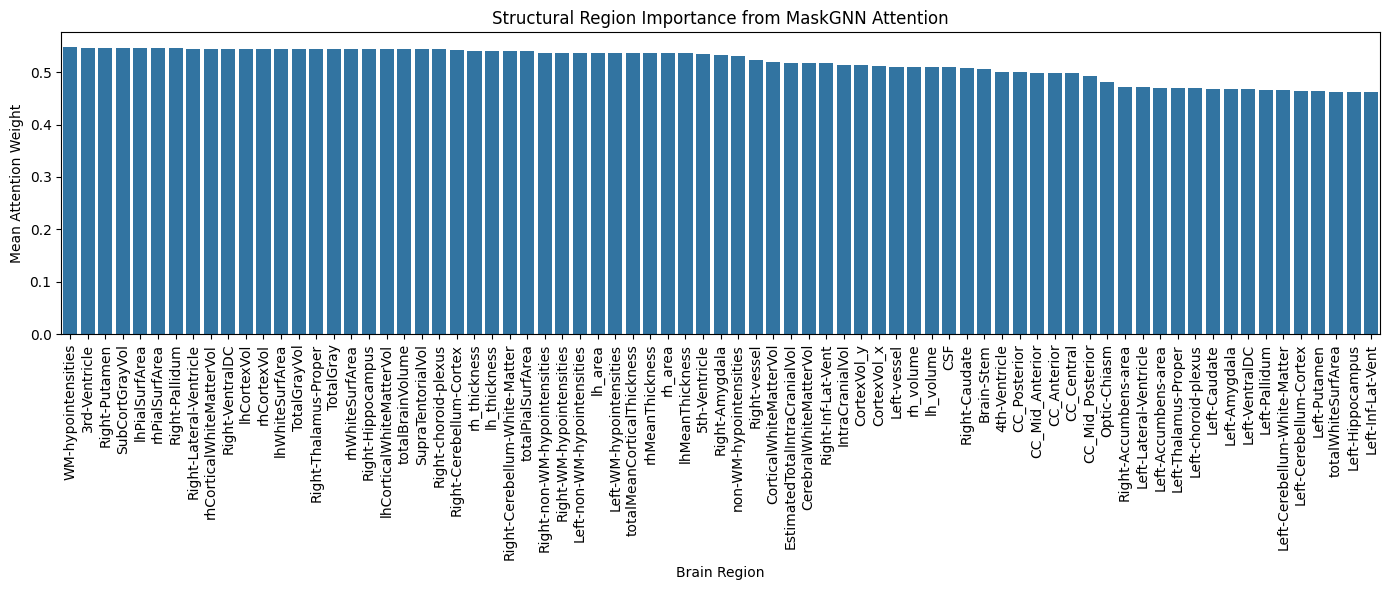

In [87]:
def get_region_importance(model, data_loader, region_names):
    model.eval()
    device = next(model.parameters()).device
    region_importance = torch.zeros(len(region_names)).to(device)
    region_counts = torch.zeros(len(region_names)).to(device)

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            
            # Forward pass up to attention
            x, edge_index, batch_idx = batch.x, batch.edge_index, batch.batch

            x1 = model.gat1(x, edge_index)
            x1 = model.norm1(x1)
            x1 = F.elu(x1)
            x1 = model.dropout_layer(x1)

            x2 = model.gat2(x1, edge_index)
            x2 = model.norm2(x2)
            x2 = F.elu(x2)
            x2 = model.dropout_layer(x2)

            x3 = model.gcn3(x2, edge_index)
            x3 = model.norm3(x3)
            x3 = F.elu(x3)
            x3 = model.dropout_layer(x3)

            x4 = model.sage4(x3, edge_index)
            x4 = model.norm4(x4)
            x4 = F.elu(x4)
            x4 = model.dropout_layer(x4)

            attention_weights = model.attention(x4).squeeze()  # Shape: (num_nodes,)

            # Accumulate attention per region
            for i in range(batch_idx.max().item() + 1):
                mask = (batch_idx == i)
                region_importance += attention_weights[mask]
                region_counts += 1  # All graphs have same number of regions

    return (region_importance / region_counts).cpu().numpy()


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

importance_scores = get_region_importance(model, val_loader, regional_data['region_names'])
region_names = regional_data['region_names']

# Sort by importance
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_importance = importance_scores[sorted_indices]
sorted_regions = [region_names[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x=sorted_regions, y=sorted_importance)
plt.xticks(rotation=90)
plt.title("Structural Region Importance from MaskGNN Attention")
plt.xlabel("Brain Region")
plt.ylabel("Mean Attention Weight")
plt.tight_layout()
plt.show()


/var/folders/49/_gwn31cj245fpwf4x7q7l7x40000gn/T/ipykernel_4696/3920542126.py:23: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(
/var/folders/49/_gwn31cj245fpwf4x7q7l7x40000gn/T/ipykernel_4696/3920542126.py:32: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(


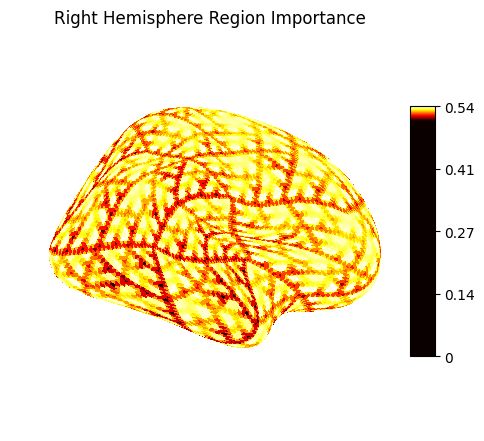

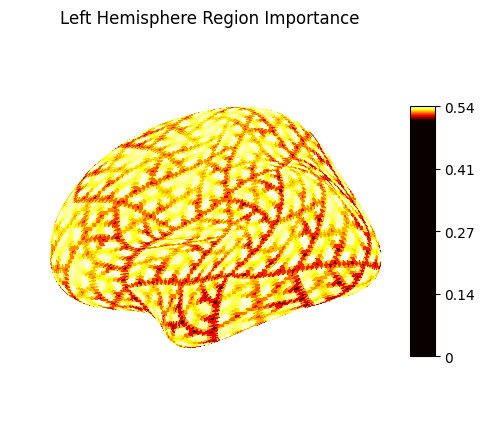

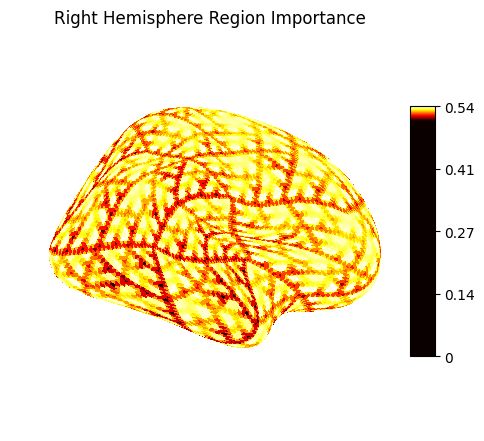

In [88]:
from nilearn import datasets, surface, plotting
import numpy as np

# Load fsaverage5 surface
fsaverage = datasets.fetch_surf_fsaverage()

# Your importance values (length must match number of regions)
# Select cortical regions only and map to left + right hemispheres
# (Desikan-Killiany has 34 per hemisphere)
cortical_mask = [i for i, r in enumerate(region_names) if r.startswith(('lh_', 'rh_'))]
cortical_regions = [region_names[i] for i in cortical_mask]
cortical_importance = importance_scores[cortical_mask]

# Sort into hemispheres
lh_values = [cortical_importance[i] for i, r in enumerate(cortical_regions) if r.startswith('lh_')]
rh_values = [cortical_importance[i] for i, r in enumerate(cortical_regions) if r.startswith('rh_')]

# Repeat values for vertices (simple interpolation)
lh_map = np.interp(np.arange(10242), np.linspace(0, 10241, len(lh_values)), lh_values)
rh_map = np.interp(np.arange(10242), np.linspace(0, 10241, len(rh_values)), rh_values)


plotting.plot_surf_stat_map(
    fsaverage['infl_left'], lh_map,
    hemi='left',
    title='Left Hemisphere Region Importance',
    colorbar=True,
    bg_map=fsaverage['sulc_left'],
    cmap='hot'
)

plotting.plot_surf_stat_map(
    fsaverage['infl_right'], rh_map,
    hemi='right',
    title='Right Hemisphere Region Importance',
    colorbar=True,
    bg_map=fsaverage['sulc_right'],
    cmap='hot'
)



In [89]:
from nilearn import datasets

# Load fsaverage5 and DK parcellation
fsaverage = datasets.fetch_surf_fsaverage()
dk_atlas = datasets.fetch_atlas_surf_destrieux()  # closest surface atlas to DK in nilearn

# Destrieux labels (10242 values, same as fsaverage mesh)
labels_left = dk_atlas['map_left']
labels_right = dk_atlas['map_right']
label_names = dk_atlas['labels']  # index corresponds to label ID


[fetch_atlas_surf_destrieux] Dataset found in /Users/joemargolis/nilearn_data/destrieux_surface


/var/folders/49/_gwn31cj245fpwf4x7q7l7x40000gn/T/ipykernel_4696/785047189.py:5: UserWarning: 
The following regions are present in the atlas look-up table,
but missing from the atlas image:

 index    name
     0 Unknown

  dk_atlas = datasets.fetch_atlas_surf_destrieux()  # closest surface atlas to DK in nilearn
/var/folders/49/_gwn31cj245fpwf4x7q7l7x40000gn/T/ipykernel_4696/785047189.py:5: UserWarning: 
The following regions are present in the atlas look-up table,
but missing from the atlas image:

 index    name
     0 Unknown

  dk_atlas = datasets.fetch_atlas_surf_destrieux()  # closest surface atlas to DK in nilearn


Top Left Hemisphere Regions:
S_orbital_lateral: 0.537
S_suborbital: 0.536
G_front_inf-Orbital: 0.535
S_precentral-sup-part: 0.535
G_precentral: 0.535

Top Right Hemisphere Regions:
Lat_Fis-ant-Horizont: 0.535
S_precentral-sup-part: 0.535
G_subcallosal: 0.535
G_and_S_paracentral: 0.534
G_front_inf-Orbital: 0.534


/var/folders/49/_gwn31cj245fpwf4x7q7l7x40000gn/T/ipykernel_4696/761496164.py:30: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(
/var/folders/49/_gwn31cj245fpwf4x7q7l7x40000gn/T/ipykernel_4696/761496164.py:40: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(


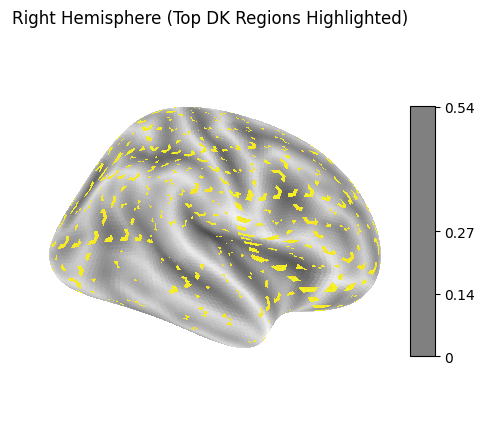

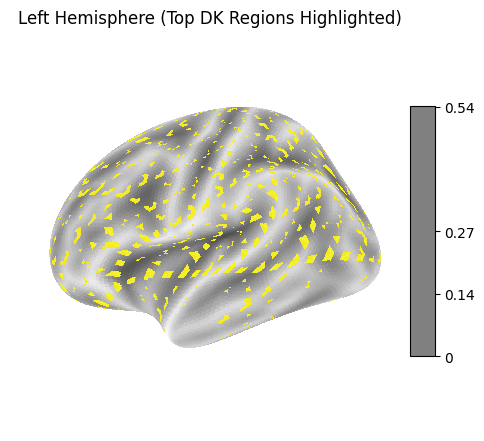

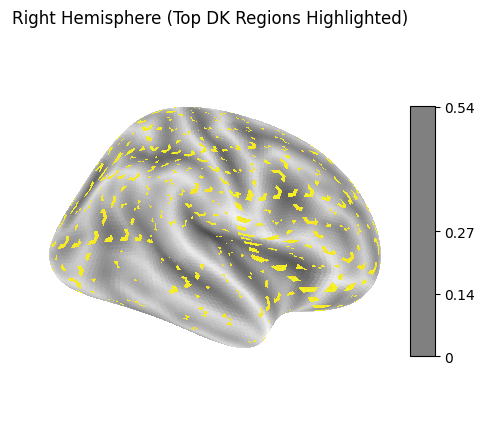

In [90]:
import numpy as np
from collections import defaultdict

def region_mean_importance(importance_map, label_map, label_names):
    region_values = defaultdict(list)

    for i, label in enumerate(label_map):
        if label == 0:  # background
            continue
        region_values[label].append(importance_map[i])

    region_mean = {label_names[k]: np.mean(v) for k, v in region_values.items()}
    # Sort descending
    return sorted(region_mean.items(), key=lambda x: x[1], reverse=True)

top_lh_regions = region_mean_importance(lh_map, labels_left, label_names)
top_rh_regions = region_mean_importance(rh_map, labels_right, label_names)

# Show top 5 from each
print("Top Left Hemisphere Regions:")
for name, score in top_lh_regions[:5]:
    print(f"{name}: {score:.3f}")

print("\nTop Right Hemisphere Regions:")
for name, score in top_rh_regions[:5]:
    print(f"{name}: {score:.3f}")

from nilearn import plotting

plotting.plot_surf_stat_map(
    fsaverage['infl_left'], lh_map,
    hemi='left',
    title='Left Hemisphere (Top DK Regions Highlighted)',
    bg_map=fsaverage['sulc_left'],
    cmap='plasma',
    threshold=np.percentile(lh_map, 80),
    vmax=np.max(lh_map)
)

plotting.plot_surf_stat_map(
    fsaverage['infl_right'], rh_map,
    hemi='right',
    title='Right Hemisphere (Top DK Regions Highlighted)',
    bg_map=fsaverage['sulc_right'],
    cmap='plasma',
    threshold=np.percentile(rh_map, 80),
    vmax=np.max(rh_map)
)

In [91]:
from nilearn import datasets
from collections import defaultdict
import numpy as np

# Load Destrieux surface atlas and label names
dk_atlas = datasets.fetch_atlas_surf_destrieux()
labels_lh = dk_atlas['map_left']
labels_rh = dk_atlas['map_right']
label_names = dk_atlas['labels']

def get_top_regions(vertex_values, label_map, label_names, top_n=10):
    region_values = defaultdict(list)

    for i, label in enumerate(label_map):
        if label == 0:  # background
            continue
        region_values[label].append(vertex_values[i])

    region_avg_importance = {
        label_names[label]: np.mean(values)
        for label, values in region_values.items()
        if label < len(label_names)
    }

    return sorted(region_avg_importance.items(), key=lambda x: x[1], reverse=True)[:top_n]

top_lh = get_top_regions(lh_map, labels_lh, label_names)
top_rh = get_top_regions(rh_map, labels_rh, label_names)

print("Top Left Hemisphere Regions:")
for name, score in top_lh:
    print(f"  {name}: {score:.3f}")

print("\nTop Right Hemisphere Regions:")
for name, score in top_rh:
    print(f"  {name}: {score:.3f}")




[fetch_atlas_surf_destrieux] Dataset found in /Users/joemargolis/nilearn_data/destrieux_surface
Top Left Hemisphere Regions:
  S_orbital_lateral: 0.537
  S_suborbital: 0.536
  G_front_inf-Orbital: 0.535
  S_precentral-sup-part: 0.535
  G_precentral: 0.535
  S_front_middle: 0.535
  S_interm_prim-Jensen: 0.534
  S_central: 0.534
  G_Ins_lg_and_S_cent_ins: 0.534
  G_temp_sup-G_T_transv: 0.534

Top Right Hemisphere Regions:
  Lat_Fis-ant-Horizont: 0.535
  S_precentral-sup-part: 0.535
  G_subcallosal: 0.535
  G_and_S_paracentral: 0.534
  G_front_inf-Orbital: 0.534
  G_precentral: 0.534
  G_and_S_frontomargin: 0.534
  S_suborbital: 0.534
  S_front_sup: 0.534
  S_pericallosal: 0.534


/var/folders/49/_gwn31cj245fpwf4x7q7l7x40000gn/T/ipykernel_4696/4213350004.py:6: UserWarning: 
The following regions are present in the atlas look-up table,
but missing from the atlas image:

 index    name
     0 Unknown

  dk_atlas = datasets.fetch_atlas_surf_destrieux()
/var/folders/49/_gwn31cj245fpwf4x7q7l7x40000gn/T/ipykernel_4696/4213350004.py:6: UserWarning: 
The following regions are present in the atlas look-up table,
but missing from the atlas image:

 index    name
     0 Unknown

  dk_atlas = datasets.fetch_atlas_surf_destrieux()
